source : https://www.kaggle.com/c/GiveMeSomeCredit <br>
by Tito Tamaro<br>
sebagai _Final Project_ JCDS Purwadhika 2020

# Table of Contents

<b>I. Import Package</b>

<b>II. Functions</b>

<b>III. Attributes Information</b>

    3.1. Data Description
    3.2. Data Distribution
        - Numerical Features
        - Categorical Features
    3.3. Boxplot

<b>IV. NaN Values</b>

<b>V. Univariate Analysis</b>
    
    5.1. SeriousDlqin2yrs
    5.2. RevolvingUtilizationOfUnsecuredLines
    5.3. Age
    5.4. NumberOfTime30-59DaysPastDueNotWorse
    5.5. DebtRatio
    5.6. MonthlyIncome
    5.7. NumberOfOpenCreditLinesAndLoans
    5.8. NumberOfTimes90DaysLate
    5.9. NumberRealEstateLoansOrLines
    5.10. NumberOfTime60-89DaysPastDueNotWorse
    5.11. NumberOfDependents
    
<b>VI. Bivariate Analysis</b>
    
    6.1. Confusion Matrix

<b>VII. Outlier Handling</b>

<b>VIII. Feature Engineering</b>

<b>IX. Split Data</b>

<b>X. Data Imputation</b>

<b>XI. Feature Selection</b>

<b>XII. Data Imbalance Handling</b>
    
    12.1 SMOTE
    12.2 Oversampling
    12.3 Undersampling

<b>XIII. Pipeline Creation</b>

<b>XIV. Fitting Model</b>

<b>XV. Hyper Parameter Tuning</b>

<b>XVI. Model Comparison</b>

<b>XVII. Risk Group Classification</b>

<b>XVIII. Result</b>

# Import Package

In [60]:
import numpy as py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score,f1_score,recall_score,precision_score,classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE 
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

warnings.filterwarnings('ignore')
%matplotlib inline

# Functions

In [61]:
def dataframe_description(dataframe,samples=2): 
    bsDESC=[]
    for i in dataframe.columns:
        bsDESC.append([
            i, 
            dataframe[i].dtypes, 
            dataframe[i].isnull().sum(), 
            round((((dataframe[i].isnull().sum()) / (len(dataframe))) * 100),2),
            dataframe[i].nunique(), 
            dataframe[i].drop_duplicates().sample(samples).values,
            round(dataframe[i].mean(),2),
            round(dataframe[i].max(),2),
            round(dataframe[i].min(),2)
        ])
    dfDesc = pd.DataFrame(bsDESC,columns=['dataFeatures','dataType','nullValues','nullPercentage','unique','sample','mean','maxValues','minValues'])
    return dfDesc 

# Attributes Information

| Variable Name | Description | Type |
| --- | --- | --- |
|SeriousDlqin2yrs|Person experienced 90 days past due delinquency or worse|Y/N|
|RevolvingUtilizationOfUnsecuredLines|Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits|percentage|
|age|Age of borrower in years|integer|
|NumberOfTime30-59DaysPastDueNotWorse|Number of times borrower has been 30-59 days past due but no worse in the last 2 years.|integer|
|DebtRatio|Monthly debt payments| percentage|living costs divided by monthy gross income|percentage|
|MonthlyIncome|Monthly income|integer|
|NumberOfOpenCreditLinesAndLoans|Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)|integer|
|NumberOfTimes90DaysLate|Number of times borrower has been 90 days or more past due.|integer|
|NumberRealEstateLoansOrLines|Number of mortgage and real estate loans including home equity lines of credit|integer|
|NumberOfTime60-89DaysPastDueNotWorse|Number of times borrower has been 60-89 days past due but no worse in the last 2 years.|integer|
|NumberOfDependents|Number of dependents in family excluding themselves (spouse or children etc.)|integer|

Data merupakan kompetisi dari kaggle pada tahun 2011 (source: https://www.kaggle.com/c/GiveMeSomeCredit) dimana peserta diminta untuk memprediksi apakah peminjam uang akan mengalami _default_ (gagal bayar). Terdapat 3 csv di dalam bundle kompetisi ini yaitu csv_training yang merupakan data utama yang digunakan untuk model fitting, csv_test merupakan data yang memiliki semua features pada csv_training namun memiliki nilai kosong (NaN) pada features targetnya, dan terakhir adalah sample yang mana merupakan contoh data yang akan disubmit dalam komeptisi. Dalam project kali ini yang akan digunakan hanyalah <b>csv_training</b>

In [62]:
df_training = pd.read_csv('cs-training.csv')
df_training.rename(columns={'Unnamed: 0':'index'},inplace=True) # mengubah Unnamed features menjadi index
df_training = df_training.set_index('index')

df_test = pd.read_csv('cs-test.csv')
df_test.rename(columns={'Unnamed: 0':'index'},inplace=True) # mengubah Unnamed features menjadi index
df_test = df_test.set_index('index')

df_sample = pd.read_csv('sampleEntry.csv')

In [63]:
print(df_training.shape) # yang akan dipakai dalam project
print(df_test.shape)
print(df_sample.shape)

(150000, 11)
(101503, 11)
(101503, 2)


In [64]:
df_training.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
index,,,,,,,,,,,
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


## Data Description

In [65]:
dataframe_description(df_training)

,dataFeatures,dataType,nullValues,nullPercentage,unique,sample,mean,maxValues,minValues
0,SeriousDlqin2yrs,int64,0,0.00,2,"[0, 1]",0.07,1.0,0.0
1,RevolvingUtilizationOfUnsecuredLines,float64,0,0.00,125728,"[0.264083564, 0.236338785]",6.05,50708.0,0.0
2,age,int64,0,0.00,86,"[73, 33]",52.30,109.0,0.0
3,NumberOfTime30-59DaysPastDueNotWorse,int64,0,0.00,16,"[4, 12]",0.42,98.0,0.0
4,DebtRatio,float64,0,0.00,114194,"[0.636060657, 0.093266254]",353.01,329664.0,0.0
5,MonthlyIncome,float64,29731,19.82,13594,"[20850.0, 19838.0]",6670.22,3008750.0,0.0
6,NumberOfOpenCreditLinesAndLoans,int64,0,0.00,58,"[50, 36]",8.45,58.0,0.0
7,NumberOfTimes90DaysLate,int64,0,0.00,19,"[1, 11]",0.27,98.0,0.0
8,NumberRealEstateLoansOrLines,int64,0,0.00,28,"[4, 25]",1.02,54.0,0.0
9,NumberOfTime60-89DaysPastDueNotWorse,int64,0,0.00,13,"[5, 8]",0.24,98.0,0.0


Dari deskripsi di atas, features dapat dikelompokkan menjadi :

- <b>Numerical Values</b>

    - RevolvingUtilizationOfUnsecuredLines
    - age
    - NumberOfTime30-59DaysPastDueNotWorse
    - DebtRatio
    - MonthlyIncome
    - NumberOfOpenCreditLinesAndLoans
    - NumberOfTimes90DaysLate
    - NumberRealEstateLoansOrLines
    - NumberOfTime60-89DaysPastDueNotWorse
    - NumberOfDependents
    
    
- <b>Categorical Values</b>

    - SeriousDlqin2yrs ==> <b>Target</b>

## Data Distribution - Numerical 

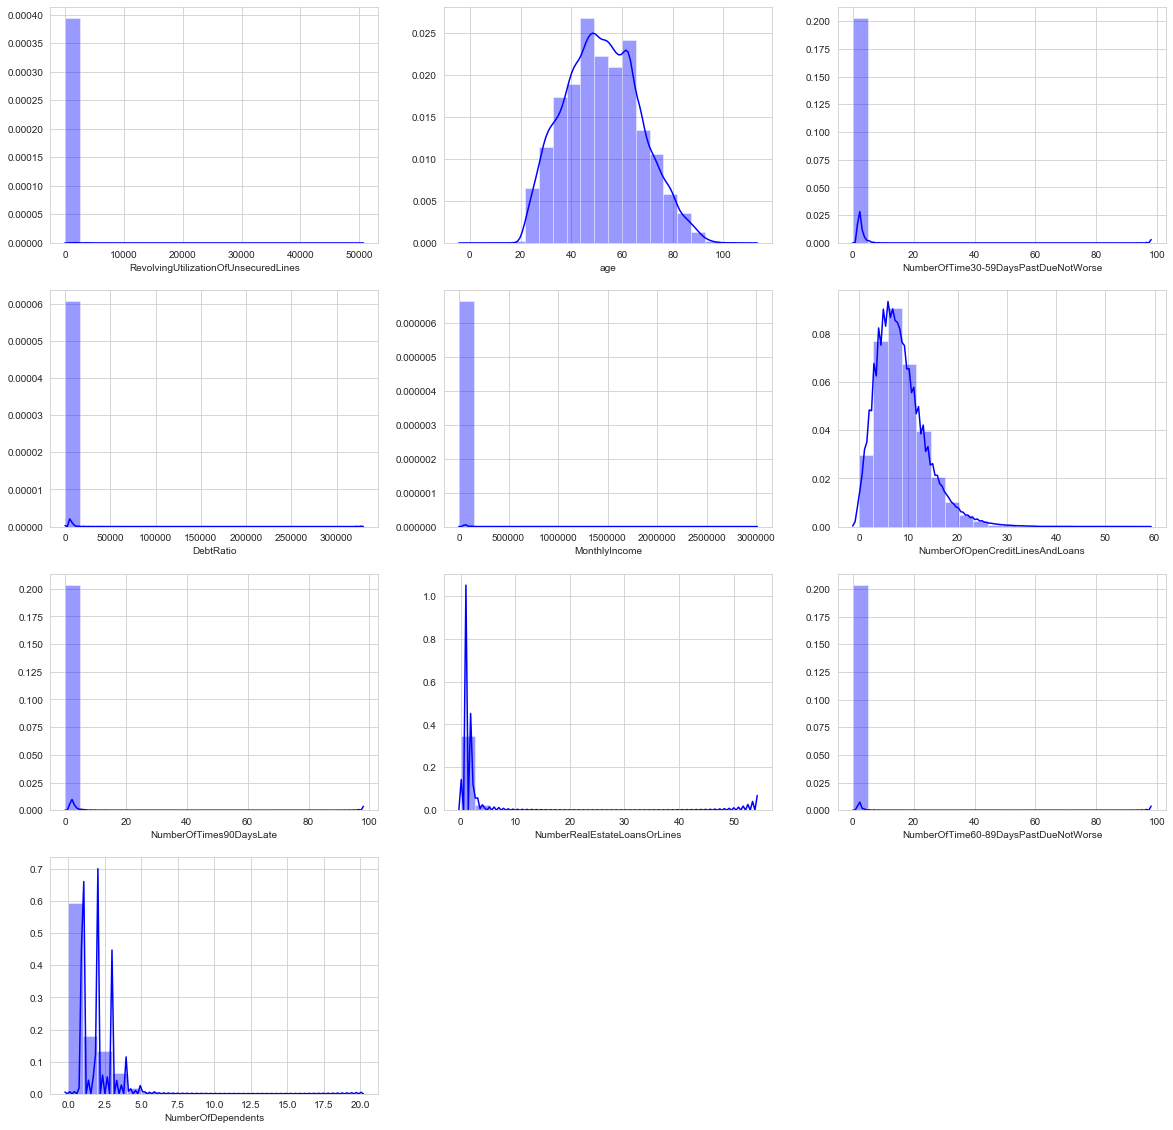

In [66]:
col = df_training.drop(['SeriousDlqin2yrs'],axis=1)
columnList = list(col)
columnList

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,11)):
    axes = fig.add_subplot(4,3,i)
    sns.distplot(df_training[j],bins=20,ax=axes, color='blue') # jumlah bins 1/10 jumlah data
plt.show()

Hampir semua features memiliki <b>skewed distribution</b>, hal ini mengindikasikan adanya outlier pada features oleh karena itu dibutuhkan tools lain (seperti boxplot) untuk bisa mendeteksi adanya outlier secara lebih akurat. Selain itu dengan persebaran data seperti ini imputasi akan lebih tepat bila menggunakan <b>median data</b>

## Boxplot

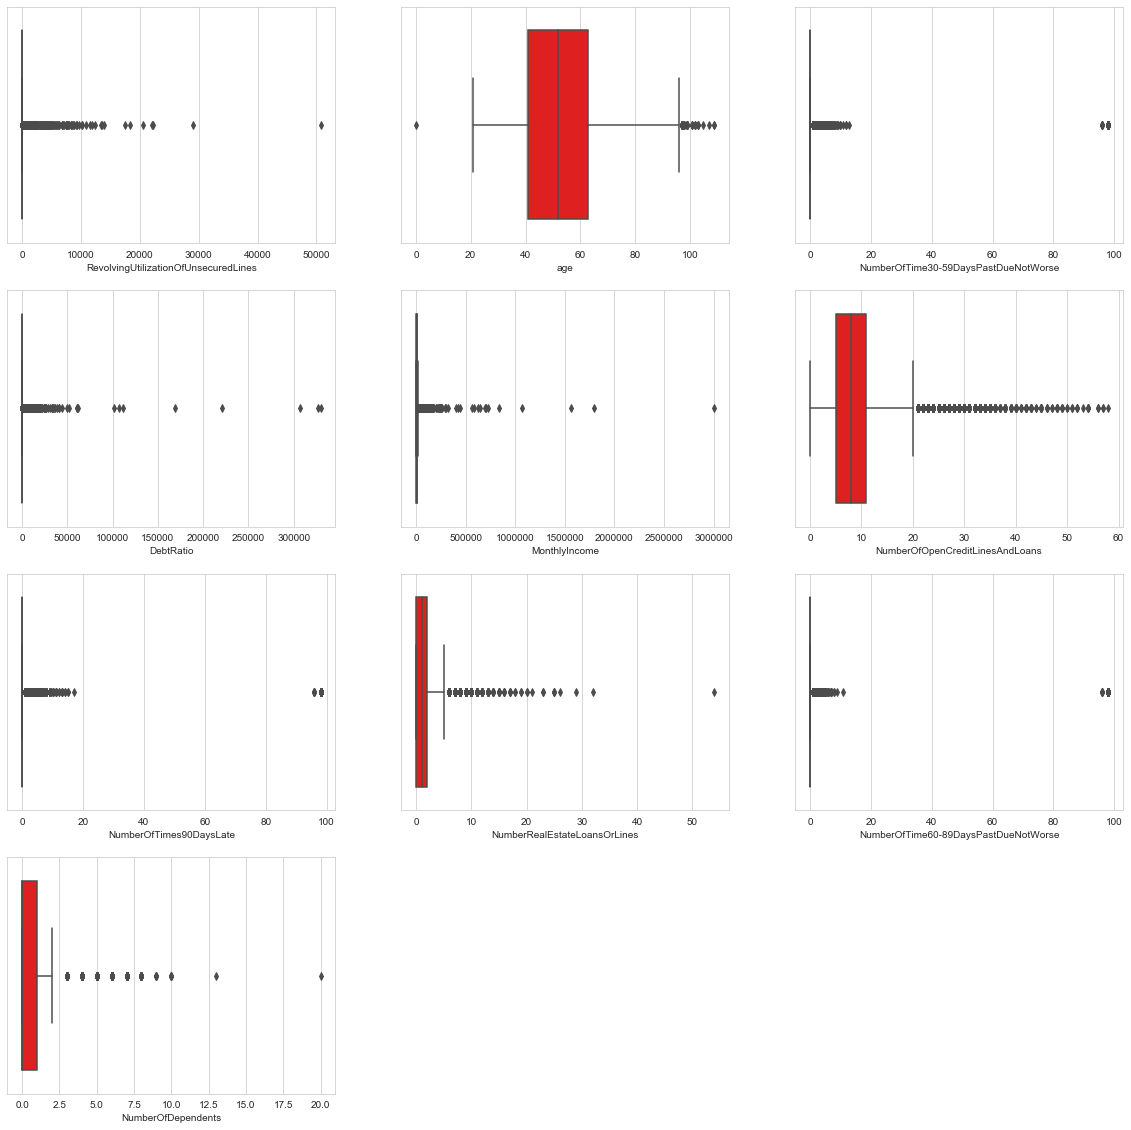

In [67]:
col = df_training.drop(['SeriousDlqin2yrs'],axis=1)
columnList = list(col)
columnList

fig = plt.figure(figsize=[20,20])
for j,i in zip(columnList,range(1,11)):
    axes = fig.add_subplot(4,3,i)
    sns.boxplot(df_training[j],ax=axes, color='red')
plt.show()

Dari boxplot ditemukan semua features memiliki <b>outlier</b>. Oleh karena itu dibutuhkan outlier handling untuk setiap features, pada project ini akan dibandingkan bagaimana performa model dengan dan tanpa outlier handling dan kemudian akan dipilih yang memiliki performa terbaik. Hal ini akan dibahas lebih dalam pada bagian outlier handling

## Data Distribution - Categorical

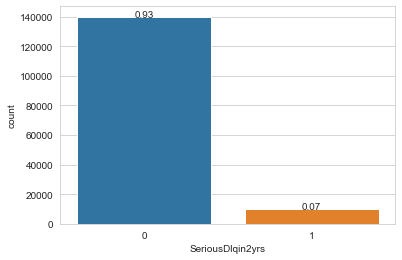

In [68]:
ax = sns.countplot(df_training['SeriousDlqin2yrs'])
total = len(df_training)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format(height/total),
            ha="center")
plt.show()

Satu-satunya jenis data categorical dalam dataset ini adalah features 'SeriousDlqin2yrs' yang mana juga menjadi kolom target. Features ini berisi nilai 0 dan 1 yang menentukan apakah seorang pengguna kredit akan mengalami _default_ / gagal bayar dalam 2 tahun kedepan. <br>
Dari jumlahnya dapat dilihat bahwa features target <b>imbalanced<b>

# NaN Values

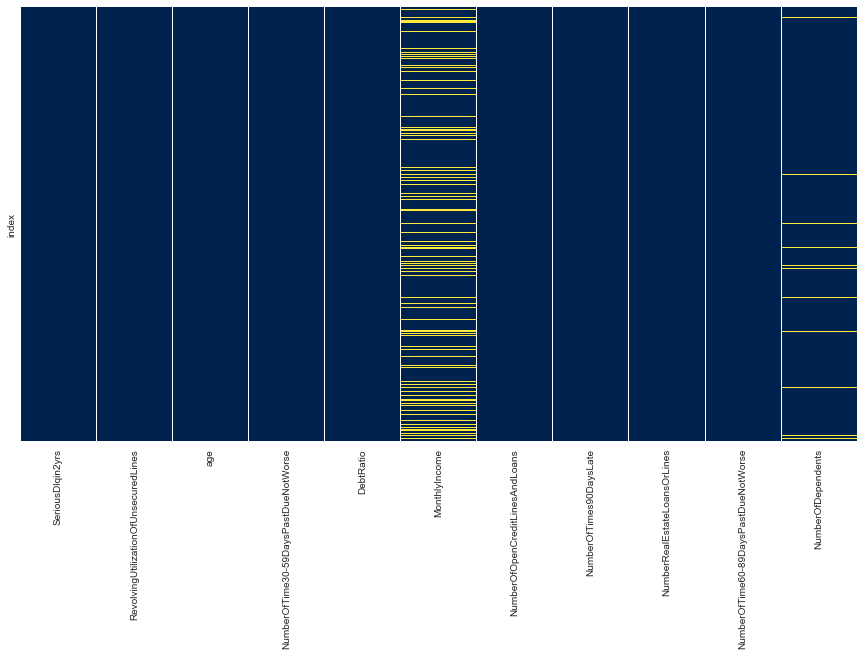

In [69]:
plt.figure(figsize=(15,8))

sns.heatmap(df_training.isna(), yticklabels=False, cmap='cividis', cbar=False)
plt.show()

In [70]:
df_training.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [71]:
29731/len(df_training)*100

19.820666666666668

In [72]:
3924/len(df_training)*100

2.616

Terdapat 29731 atau 19.82% NaN Values pada features MonthlyIncome<br>
Terdapat 3924 atau 2.62 % NaN Values pada features MonthlyIncome

#### Pengaruh NaN Values terhadap Target

In [73]:
df_training['nullValuesMI'] = pd.isnull(df_training['MonthlyIncome'])
df1 = pd.crosstab(index=df_training.nullValuesMI, columns=df_training.SeriousDlqin2yrs, values=df_training.nullValuesMI,aggfunc='count',normalize='all')
df1

SeriousDlqin2yrs,0,1
nullValuesMI,,
False,0.74608,0.055713
True,0.18708,0.011127


NaN Values pada features Monthly Income memiliki persentase 18,7% pada nilai target 0 dan 1,1% pada nilai target 1 

In [74]:
df_training['nullValuesND'] = pd.isnull(df_training['NumberOfDependents'])
df2 = pd.crosstab(index=df_training.nullValuesND, columns=df_training.SeriousDlqin2yrs, values=df_training.nullValuesND,aggfunc='count',normalize='all')
df2

SeriousDlqin2yrs,0,1
nullValuesND,,
False,0.908193,0.065647
True,0.024967,0.001193


NaN Values pada features Number Of Dependents memiliki persentase 2,4% pada nilai target 0 dan 0.1 % pada nilai target 1

Berdarkan nilai diatas akan dilakukan 3 metode imputasi lalu akan diambil yang memiliki performa modelling terbaik, yaitu :
1. Mengganti NaN value dengan median seluruh data
2. Mengganti NaN value dengan nilai -999
3. Mengganti NaN value dengan median namun setelah dikelompokkan berdasarkan features yang lain

Drop value tidak dilakukan karena akan mengubah data dalam jumlah besar (hampir 20% data akan hilang apabila semua NaN value di drop)<br>
Imputasi data akan dilakukan saat data sudah di split dalam bagian modelling. Hal ini dilakukan untuk mencegah <b>Data Leakage</b>

## Univariate Analysis

Dalam bagian ini akan dibahas pengaruh setiap features terhadap target, pembahasan akan dilakukan terpisah antara features yang satu dengan yang lain

### SeriousDlqin2yrs (Target)

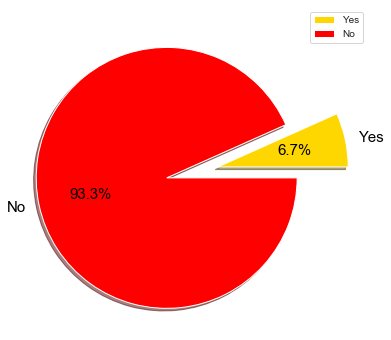

In [75]:
y = (len(df_training[df_training['SeriousDlqin2yrs']==1])/len(df_training))*100
n = (len(df_training[df_training['SeriousDlqin2yrs']!=1])/len(df_training))*100
persentase = [y,n]
nama = ['Yes','No']

plt.figure(figsize=(7,6))
plt.pie(
    persentase, 
    labels=nama,
    colors=['gold','red'],
    startangle= 0,
    shadow=True,
    textprops={
        'size':15 ,
        'color':'k'
    },
    autopct='%1.1f%%', # float format
    explode=(.1,0.3)
)
plt.legend()
plt.show()

Terdapat 6.7% nasabah yang mengalami _default_ / gagal bayar, dan sisanya yaitu 93.3% tidak. Ketimpangan jumlah ini menandakan adanya <b>imbalance data</b> dan dibutuhkan imbalance data handling pada tahap modelling.

### RevolvingUtilizationOfUnsecuredlines vs Target

In [76]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns=['RUUL'], values=df_training.RevolvingUtilizationOfUnsecuredLines, aggfunc=['mean','median'])

,mean,median
col_0,RUUL,RUUL
SeriousDlqin2yrs,,
0,6.168855,0.133288
1,4.367282,0.838853


Feature RevolvingUtilizationOfUnsecuredlines merupakan fitur yang menggambarkan rasio kredit yang dipakai terhadap limit kredit. Idealnya nilai fitur ini bernilai <30 % dimana angka ini dinilai baik dan semakin kecil jumlah kredit yang dipakai akan semakin baik.
Berdasarkan tabel diatas, menggambarkan bahwa customer yang mengalami default memiliki median RUUL sebesar 83%, sementara yang tidak mengalami default memiliki median RUUL sebesar 13.3%. Mean di atas tidak digunakan dalam analisis data karena distribusi data _highly skewed_, sehingga nilai median lebih representatif untuk menganalisis data. Nilai mean di atas ditampilkan hanya sebagai pelengkap saja

### Age vs Target

In [77]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns=['Age'], values=df_training.age, aggfunc=['mean','median'])

,mean,median
col_0,Age,Age
SeriousDlqin2yrs,,
0,52.751375,52
1,45.926591,45


In [78]:
# binning data by interval 10
bins = [-1,21,31,41,51,61,71,81,91,101,111] # binning dengan interval 10 kecuali yang pertama karena hanya ditemukan 1 data dengan age 0 (outlier)
label = ['(0-20)','(21-30)','(31-40)','(41-50)','(51-60)','(61-70)','(71-80)','(81-90)','(91-100)','(101-111)'] # label umur
df_training['binned_age']=pd.cut(df_training['age'],bins=bins,labels=label)

In [79]:
pd.crosstab(index=df_training.binned_age, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_age                          
(0-20)            0.001140  0.000087
(21-30)           0.074427  0.009653
(31-40)           0.153040  0.016447
(41-50)           0.217800  0.019147
(51-60)           0.217667  0.013673
(61-70)           0.164860  0.005460
(71-80)           0.077087  0.001767
(81-90)           0.024947  0.000567
(91-100)          0.002127  0.000040
(101-111)         0.000067  0.000000

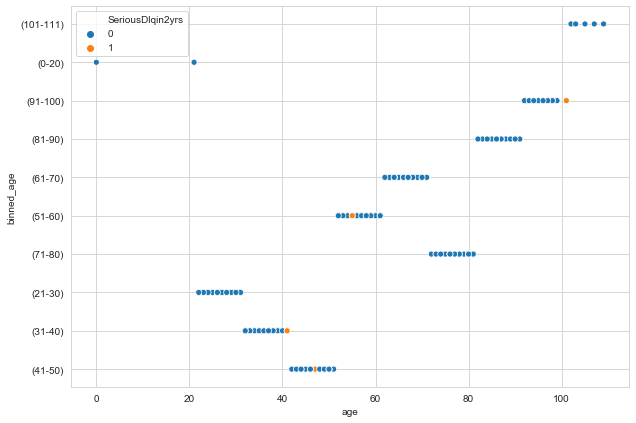

In [80]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=df_training.age,y=df_training.binned_age,hue=df_training.SeriousDlqin2yrs,data=df_training)
plt.show()

Data age merupakan satu-satunya features yang memiliki bentuk distribusi mendekati distribusi normal, oleh karena itu baik nilai mean ataupun median dapat digunakan sebagai analisis. Rata-rata usia yang mengalami gagal bayar adalah usia 45 tahun, dan yang tidak adalah 52 tahun. Kesimpulan ini kurang bermanfaat dalam analisis oleh karena itu usia akan dikelompokkan agar dapat dilihat kelompok usia mana yang paling banyak mengalami gagal bayar. Dari hasil pengelompokkan dapat dilihat bahwa kelompok usia 41-50 tahun paling banyak mengalami gagal bayar dengan persentase 19.1% terhadap keseluruhan data. Dari scatterplot di atas dapat dilihat juga kecenderungan gagal bayar dimulai terdeteksi pada customer dengan usia 40 tahun ke atas.

### NumberOfTime30-59DaysPastDueNotWorse vs Target

In [81]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='NT3059', values=df_training['NumberOfTime30-59DaysPastDueNotWorse'], aggfunc=['mean','median'])

,mean,median
col_0,NT3059,NT3059
SeriousDlqin2yrs,,
0,0.280109,0
1,2.388490,0


In [82]:
print(df_training['NumberOfTime30-59DaysPastDueNotWorse'].max())
print(df_training['NumberOfTime30-59DaysPastDueNotWorse'].min())

98
0


In [83]:
# binning data
bins = [-1,4,8,12,16,20,24,91,101] # binning dengan interval 3, kecuali dari nilai 90 keatas(terdapat kekosongan data pada interval 27 sampai 90)  
label = ['(0-3)','(4-7)','(8-11)','(12-15)','(16-19)','(20-23)','(24-27)','(27-100)'] # label
df_training['binned_NT3059']=pd.cut(df_training['NumberOfTime30-59DaysPastDueNotWorse'],bins=bins,labels=label)

In [84]:
pd.crosstab(index=df_training.binned_NT3059, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_NT3059                       
(0-3)             0.930300  0.064033
(4-7)             0.001980  0.001760
(8-11)            0.000067  0.000060
(12-15)           0.000000  0.000007
(27-100)          0.000813  0.000980

Features NumberOfTime30-59DaysPastDueNotWorse bernilai bilangan bulat yang menyatakan berapa kali customer mengalami keterlambatan bayar dalam kurun waktu 30-59 hari. Dalam tabel ditemukan nilai median 0, hal ini disebabkan karena banyaknya nilai 0 pada features ini yang berarti customer tersebut tidak mengalami keterlambatan bayar. Selanjutnya data ini di binning dengan interval 3 poin, terdapat kekosongan data pada interval 27 sampai 90 sehingga terdapat loncatan dalam pengelompokannya. Dari tabel diatas diketahui kelompok customer dengan nilai NumberOfTime30-59DaysPastDueNotWorse 0-3 merupakan yang paling sering mengalami gagal bayar.

### DebtRatio vs Target

In [85]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='DR', values=df_training['DebtRatio'], aggfunc=['mean','median'])

,mean,median
col_0,DR,DR
SeriousDlqin2yrs,,
0,357.151168,0.362659
1,295.121066,0.428227


In [86]:
print(df_training['DebtRatio'].max())
print(df_training['DebtRatio'].min())

329664.0
0.0


In [87]:
# binning data
bins = [-1,3,6,9,12,15,18,21,101,501,1001,5001,329665] 
label = ['(0-2)','(3-5)','(6-8)','(9-11)','(12-14)','(15-17)','(18-20)','(21-100)','(101-500)','(501-1000)','(1001-5000)','(5001-329664)'] # label 
df_training['binned_DR']=pd.cut(df_training['DebtRatio'],bins=bins,labels=label)

In [88]:
pd.crosstab(index=df_training.binned_DR, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_DR                           
(0-2)             0.742480  0.055633
(3-5)             0.005247  0.000293
(6-8)             0.002833  0.000140
(9-11)            0.002393  0.000073
(12-14)           0.002133  0.000107
(15-17)           0.001613  0.000080
(18-20)           0.001827  0.000087
(21-100)          0.021640  0.001047
(101-500)         0.023000  0.002067
(501-1000)        0.022953  0.001787
(1001-5000)       0.097913  0.004787
(5001-329664)     0.009127  0.000740

Debt Ratio merupakan rasio jumlah tagihan yang harus dibayarkan terhadap total kredit. Seharusnya nilai ini dibawah 1 / 100% namun ditemukan nilai diatas 1 bahkan sampai di angka 329664, hal ini dapat terjadi karena kesalahan input data ataupun keterlambatan bayar. Nilai yang dipakai dalam analisis adalah nilai median karena data distribusi features ini _highly skewed_. Pada tabel nilai 42% keatas untuk DR merupakan kelompok customer yang mengalami gagal bayar, sementara nilai 36% kebawah merupakan kelompok customer yang tidak. FICO sendiri memberikan standard bahwa nilai DR yang baik ada di angka 30 %
Data ini bisa dibuat lebih jelas dengan metode binning, dimana pengelompokkan dijadikan per 2 poin. Dalam tabel kelompok DR 0-2 merupakan kelompok customer yang paling banyak mengalami gagal bayar sebanyak 5,5%, ditemukan juga kelompok customer yang mengalami gagal bayar pada kelompok DR > 21. Dari definisinya tidak mungkin nilai DR bisa mencapai ribuan  

### MonthlyIncome vs Target

In [89]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='MI', values=df_training['MonthlyIncome'], aggfunc=['mean','median'])

,mean,median
col_0,MI,MI
SeriousDlqin2yrs,,
0,6747.837774,5466.0
1,5630.826493,4500.0


In [90]:
print(df_training['MonthlyIncome'].max())
print(df_training['MonthlyIncome'].min())

3008750.0
0.0


In [91]:
# binning data menjadi 3 kelompok
bins = [-1,50001,150001,3008751] # binning menjadi 3 kelompok
label = ['(0-50000)','(50001-150000)','(150001-3008750)'] # label 
df_training['binned_MI']=pd.cut(df_training['MonthlyIncome'],bins=bins,labels=label)

In [92]:
pd.crosstab(index=df_training.binned_MI, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_MI                           
(0-50000)         0.928153  0.069345
(50001-150000)    0.002070  0.000125
(150001-3008750)  0.000291  0.000017

Pada features MonthlyIncome, customer yang paling banyak mengalami default atau gagal bayar adalah kelompok Monthly Income dibawah 50000 yaitu sebanyak 6.9%. Dari tabel ini juga dapat diperoleh hubungan semakin besar nilai MI maka akan semakin kecil kemungkinannya untuk default

### NumberOfOpenCreditLinesAndLoans vs Target

In [93]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='NOCLL', values=df_training['NumberOfOpenCreditLinesAndLoans'], aggfunc=['mean','median'])

,mean,median
col_0,NOCLL,NOCLL
SeriousDlqin2yrs,,
0,8.493620,8
1,7.882306,7


In [94]:
print(df_training['NumberOfOpenCreditLinesAndLoans'].max())
print(df_training['NumberOfOpenCreditLinesAndLoans'].min())

58
0


In [95]:
# binning data 
bins = [-1,11,21,31,41,51,59] # binning dengan interval 10
label = ['(0-10)','(11-20)','(21-30)','(31-40)','(41-50)','(51-58)'] # label 
df_training['binned_NOCLL']=pd.cut(df_training['NumberOfOpenCreditLinesAndLoans'],bins=bins,labels=label)

In [96]:
pd.crosstab(index=df_training.binned_NOCLL, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_NOCLL                        
(0-10)            0.717153  0.051587
(11-20)           0.196693  0.013793
(21-30)           0.017593  0.001313
(31-40)           0.001380  0.000100
(41-50)           0.000267  0.000033
(51-58)           0.000073  0.000013

Pada features NumberOfOpenCreditLinesAndLoans yang memiliki distribusi _highly skewed_ memiliki median 7 untuk customer yang mengalami default dan 8 untuk yang tidak. Features ini mememuat data tentang berapa jumlah kredit lain yang dimiliki customer selain credit yang dipakai ini. Dari hasil pengelompokkan didapat kelompok customer dengan NOCLL 0-10 memiliki jumlah default paling banyak yaitu 5.1%. Diperoleh juga kecenderungan bahwa semakin banyak nilai NOCLL yang dimiliki maka akan semakin sedikit juga jumlah customer yang mengalami gagal bayar

### NumberOfTimes90DaysLate vs Target

In [97]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='NT90', values=df_training['NumberOfTimes90DaysLate'], aggfunc=['mean','median'])

,mean,median
col_0,NT90,NT90
SeriousDlqin2yrs,,
0,0.135225,0
1,2.091362,0


In [98]:
print(df_training['NumberOfTimes90DaysLate'].max())
print(df_training['NumberOfTimes90DaysLate'].min())

98
0


In [99]:
# binning data
bins = [-1,4,8,12,16,20,24,91,101] # binning dengan interval 3, kecuali dari nilai 90 keatas(terdapat kekosongan data pada interval 27 sampai 90)  
label = ['(0-3)','(4-7)','(8-11)','(12-15)','(16-19)','(20-23)','(24-27)','(27-100)'] # label
df_training['binned_NT90']=pd.cut(df_training['NumberOfTimes90DaysLate'],bins=bins,labels=label)

In [100]:
pd.crosstab(index=df_training.binned_NT90, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_NT90                         
(0-3)             0.931620  0.064500
(4-7)             0.000620  0.001180
(8-11)            0.000073  0.000153
(12-15)           0.000033  0.000020
(16-19)           0.000000  0.000007
(27-100)          0.000813  0.000980

Features NT90 ini mirip dengan yang ada sebelumnya yaitu NT3059 dimana terdapat mencakup data berapa kali terjadi keterlambatan bayar oleh customer. Pada nilai median, features ini juga memiliki nilai 0 karena banyak terdapat data dengan nilai 0. Setelah dikelompokkan, customer dengan nilai NT90 0-3 memiliki jumlah default paling banyak yaitu 6.4%. Pada nilai max di features ini terdapat data dengan nilai sama yang juga terdapat pada NT3059 yaitu 98, hal ini mengindikasikan adanya kesalahan pada input data. Hal ini akan semakin diperkuat apabila ditemukan kembali hal yang sama pada feature yang serupa berikutnya. 

### NumberRealEstateLoansOrLines vs Target

In [101]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='NRELL', values=df_training['NumberRealEstateLoansOrLines'], aggfunc=['mean','median'])

,mean,median
col_0,NRELL,NRELL
SeriousDlqin2yrs,,
0,1.020368,1
1,0.988530,1


In [102]:
print(df_training['NumberRealEstateLoansOrLines'].max())
print(df_training['NumberRealEstateLoansOrLines'].min())

54
0


In [103]:
# binning data
bins = [-1,11,21,31,41,51,55] # binning dengan interval 10 
label = ['(0-10)','(11-20)','(21-30)','(31-40)','(41-50)','(51-54)'] # label
df_training['binned_NRELL']=pd.cut(df_training['NumberRealEstateLoansOrLines'],bins=bins,labels=label)

In [104]:
pd.crosstab(index=df_training.binned_NRELL, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_NRELL                        
(0-10)            0.932813  0.066713
(11-20)           0.000300  0.000113
(21-30)           0.000033  0.000013
(31-40)           0.000007  0.000000
(51-54)           0.000007  0.000000

Features ini mencakup data berapa banyak kredit/pinjaman yang dimiliki customer dalam properti. Features ini memiliki median 1, setelah pengelompokkan customer dengan nilai NRELL 0-10 memiiki jumlah customer yang paling banyak mengalami default yaitu 6.67%. Selain itu ditemukan juga kecenderungan bahwa semakin banyak nilai NRELL yang dimiliki oleh customer maka akan semakin kecil juga jumlah yang mengalami default.

### NumberOfTime60-89DaysPastDueNotWorse vs Target

In [105]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='NT6089', values=df_training['NumberOfTime60-89DaysPastDueNotWorse'], aggfunc=['mean','median'])

,mean,median
col_0,NT6089,NT6089
SeriousDlqin2yrs,,
0,0.126666,0
1,1.828047,0


In [106]:
print(df_training['NumberOfTime60-89DaysPastDueNotWorse'].max())
print(df_training['NumberOfTime60-89DaysPastDueNotWorse'].min())

98
0


In [107]:
# binning data
bins = [-1,4,8,12,16,20,24,91,101] # binning dengan interval 3, kecuali dari nilai 90 keatas(terdapat kekosongan data pada interval 27 sampai 90)  
label = ['(0-3)','(4-7)','(8-11)','(12-15)','(16-19)','(20-23)','(24-27)','(27-100)'] # label
df_training['binned_NT6089']=pd.cut(df_training['NumberOfTime60-89DaysPastDueNotWorse'],bins=bins,labels=label)

In [108]:
pd.crosstab(index=df_training.binned_NT6089, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_NT6089                       
(0-3)             0.932193  0.065593
(4-7)             0.000147  0.000260
(8-11)            0.000007  0.000007
(27-100)          0.000813  0.000980

Features ini mencakup data berapa kali customer mengalami keterlambatan bayar dalam kurun waktu 60-89 hari. Hal yang sama ditemukan pada features ini,NT90,dan NT3059 dimana kesemuanya memiliki median 0 yang disebabkan oleh banyaknya data yang bernilai 1. Lalu diperoleh juga nilai max yang sama yaitu 98, pada proses Outlier Handling nilai ini akan didrop karena mengindikasikan salah input (tercantum pada ketiga features dan nilainya tidak masuk akal).
Pada features ini kelompok customer dengan nilai NT6089 0-3 yang memiliki jumlah default paling banyak yaitu sebesar 6.5%

### NumberOfDependents vs Target

In [109]:
pd.crosstab(index=df_training.SeriousDlqin2yrs, columns='ND', values=df_training['NumberOfDependents'], aggfunc=['mean','median'])

,mean,median
col_0,ND,ND
SeriousDlqin2yrs,,
0,0.743417,0.0
1,0.948208,0.0


In [110]:
print(df_training['NumberOfDependents'].max())
print(df_training['NumberOfDependents'].min())

20.0
0.0


In [111]:
# binning data
bins = [-1,5,10,15,21] # binning dengan interval 5  
label = ['(0-5)','(6-10)','(11-15)','(15-21)'] # label
df_training['binned_ND']=pd.cut(df_training['NumberOfDependents'],bins=bins,labels=label)

In [112]:
pd.crosstab(index=df_training.binned_ND, columns=df_training.SeriousDlqin2yrs, values=df_training.SeriousDlqin2yrs, aggfunc=['count'],normalize=True)

count          
SeriousDlqin2yrs         0         1
binned_ND                           
(0-5)             0.931125  0.067198
(6-10)            0.001451  0.000212
(11-15)           0.000007  0.000000
(15-21)           0.000007  0.000000

Features ini mencakup data yang menunjukkan berapa jumlah tanggungan (anak, keluarga, dll.) yang dimiliki oleh customer. Pada nilai median features ini memiliki nilai 0, hal ini sama dengan features sebelumnya disebabkan oleh banyaknya data dengan nilai 0. Kelompok customer dengan nilai ND 0-5 memiliki jumlah default paling banyak yaitu 6.7%. Terdapat kecenderungan semakin banyak jumlah dependents yang dimiliki oleh customer maka semakin kecil jumlah customer yang mengalami default. 

## Bivariate Analysis

Sebelum dilakukan bivariate analysis, kolom yang tidak dibutuhkan akan didrop terlebih dahulu

In [113]:
df_training.drop(['binned_age','binned_NT3059','binned_MI','binned_DR','binned_NOCLL','binned_NT90','binned_NRELL','binned_NT6089','binned_ND','nullValuesMI','nullValuesND'],axis=1,inplace=True)

### Correlation Matrix

(11, 0)

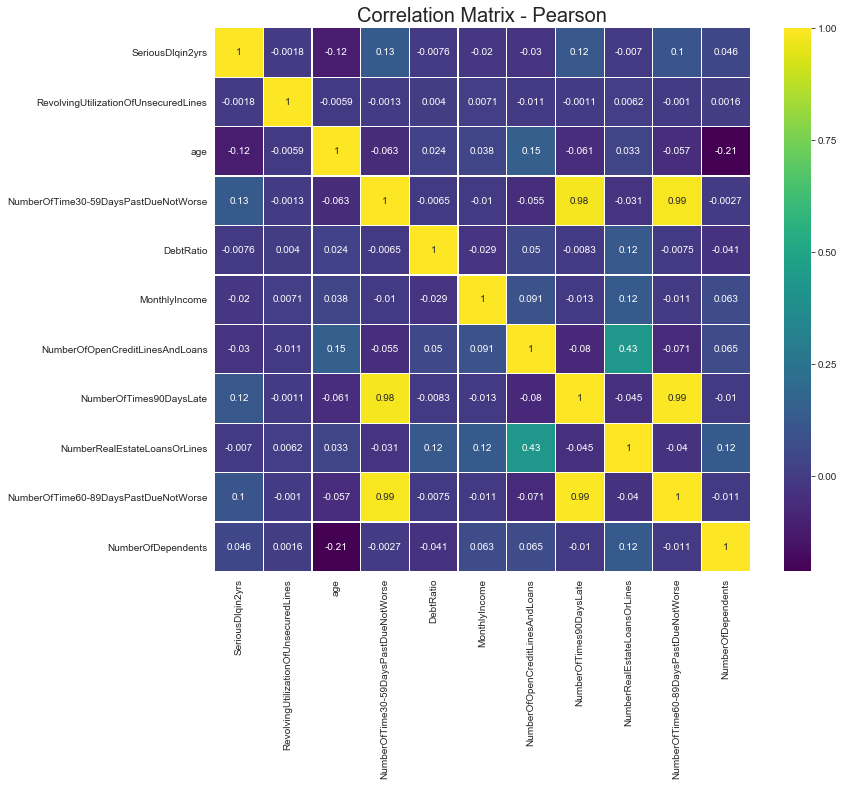

In [115]:
plt.figure(figsize=(12,10))
plt.title('Correlation Matrix - Pearson',size=20)
x = sns.heatmap(df_training.corr(),annot=True,linewidths=0.2,cmap='viridis')
x.set_ylim(11,0)

- Korelasi positif terkuat terhadap target terdapat pada features NumberOfTime30-59DaysPastDueNotWorse yaitu sebesar 0.13. Selain itu kekuatan korelasi yang sama ditemukan juga pada features NumberOfTimes90DaysLate sebesar 0.12 dan NumberOfTime60-89DaysPastDueNotWorse sebesar 1. Dari hal ini dapat disimpulkan bahwa adanya keterlambatan pembayaran kredit memiliki korelasi yang kuat dengan customer yang default

- Korelasi negatif terkuat terhadap terget terdapat pada features age yaitu sebesar -0.12. Hal ini menandakan bahwa semakin besar usia seorang customer maka semakin jumlahnya yang mengalami default.

# Outlier Handling

Outlier Handling yang akan dilakukan menggunakan upper fence dan lower fence sebagai batasannya dimana :<br> 
<b>IQR = Q3 - Q1<br>
Upper Fence = Q3 + 1.5 X IQR<br>
Lower Fence = Q1 - 1.5 x IQR</b><br>
Dimana nilai feature yang diatas Upper Fence dan dibawah Lower Fence akan dianggap sebagai <b>Outlier</b><br>
Jelas kondisinya akan disesuaikan dengan kondisi feature, dimana terdapat nilai outlier akan <b>dihapus / dibiarkan</b>.

### Outlier Handling for 'RevolvingUtilizationOfUnsecuredLines'

- <b>IQR Calculation</b>

In [116]:
IQR_RUUL = (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)) - (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)) # IQR
lower_fence_RUUL = (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.25)) - (1.5 * IQR_RUUL) # Q1 - 1.5 X IQR
upper_fence_RUUL = (df_training['RevolvingUtilizationOfUnsecuredLines'].quantile(0.75)) + (1.5 * IQR_RUUL) # Q3 + 1.5 X IQR
print(f'Lower Fence RUUL : {lower_fence_RUUL}')
print(f'Upper Fence RUUL : {upper_fence_RUUL}')

Lower Fence RUUL : -0.7639007662499999
Upper Fence RUUL : 1.35281445575


- <b>Filter Outliers</b>

In [117]:
jumlah_outlier_RUUL = len(df_training[df_training['RevolvingUtilizationOfUnsecuredLines'] < lower_fence_RUUL]) + len(df_training[df_training['RevolvingUtilizationOfUnsecuredLines'] > upper_fence_RUUL]) 
persen_RUUL = (jumlah_outlier_RUUL / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_RUUL} data ({persen_RUUL})%')

Jumlah Outlier yang akan dihandle adalah : 763 data (0.5086666666666666)%


- <b>Drop Outliers</b>

In [118]:
df_training.drop(df_training[df_training['RevolvingUtilizationOfUnsecuredLines']<lower_fence_RUUL].index,axis=0,inplace=True)
df_training.drop(df_training[df_training['RevolvingUtilizationOfUnsecuredLines']>upper_fence_RUUL].index,axis=0,inplace=True)

### Outlier Handling for 'age'

- <b>IQR Calculation</b>

In [119]:
IQR = (df_training['age'].quantile(0.75)) - (df_training['age'].quantile(0.25)) # IQR
lower_fence_age = (df_training['age'].quantile(0.25)) - (1.5 * IQR) # Q1 - 1.5 X IQR
upper_fence_age = (df_training['age'].quantile(0.75)) + (1.5 * IQR) # Q3 + 1.5 X IQR
print(f'Lower Fence age : {lower_fence_age}')
print(f'Upper Fence age : {upper_fence_age}')

Lower Fence age : 8.0
Upper Fence age : 96.0


- <b>Filter Outliers</b>

In [120]:
jumlah_outlier_age = len(df_training[df_training['age'] < lower_fence_age]) 
persen_age = (jumlah_outlier_age / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_age} data ({persen_age})%')

Jumlah Outlier yang akan dihandle adalah : 1 data (0.0006700751154204386)%


- <b>Drop Outliers</b>

In [121]:
df_training.drop(df_training[df_training['age']<lower_fence_age].index,axis=0,inplace=True)

### Outlier Handling for 'NumberOfTime30-59DaysPastDueNotWorse'

- <b>IQR Calculation</b>

In [122]:
IQR_NT3059 = (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.75)) - (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.25)) # IQR
lower_fence_NT3059 = (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.25)) - (1.5 * IQR_NT3059) # Q1 - 1.5 X IQR
upper_fence_NT3059 = (df_training['NumberOfTime30-59DaysPastDueNotWorse'].quantile(0.75)) + (1.5 * IQR_NT3059) # Q3 + 1.5 X IQR
print(f'Lower Fence NT3059 : {lower_fence_NT3059}')
print(f'Upper Fence NT3059 : {upper_fence_NT3059}')

Lower Fence NT3059 : 0.0
Upper Fence NT3059 : 0.0


Dapat dilihat bahwa Lower Fence dan Upper Fence adalah 0, hal ini disebabkan oleh nilai IQR yang 0. Nilai IQR ini disebabkan oleh banyaknya data bernilai 0 dalam features NumberOfTime30-59DaysPastDueNotWorse. Oleh karena itu outlier handling akan dilakukan secara manual.

- <b>Filter Outliers</b>

In [123]:
df_training['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()

0     125562
1      15857
2       4521
3       1720
4        733
5        338
98       264
6        138
7         53
8         25
9         12
96         5
10         4
12         2
13         1
11         1
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64

Dapat dilihat pada jumlah unik data (value_counts) pada features ini, bahwa terdapat value 96 dan 98. Kemungkinan besar ini merupakan typo (salah ketik) yang dilakukan oleh penyedia data. Features NumberOfTime30-59DaysPastDueNotWorse menunjukkan berapa kali pemilik kredit mengalami keterlambatan bayar dalam kurun waktu 30-59 hari, bila dihitung (96 * 50 hari) adalah 13 tahun yang mana mustahil, sehingga value features 96 dan 98 dihapus

- <b>Drop Outliers</b>

In [124]:
df_training.drop(df_training[df_training['NumberOfTime30-59DaysPastDueNotWorse']==96].index,axis=0,inplace=True)
df_training.drop(df_training[df_training['NumberOfTime30-59DaysPastDueNotWorse']==98].index,axis=0,inplace=True)

### Outlier Handling for 'DebtRatio'

- <b>IQR Calculation</b>

In [125]:
IQR_DR = (df_training['DebtRatio'].quantile(0.75)) - (df_training['DebtRatio'].quantile(0.25)) # IQR
lower_fence_DR = (df_training['DebtRatio'].quantile(0.25)) - (1.5 * IQR_DR) # Q1 - 1.5 X IQR
upper_fence_DR = (df_training['DebtRatio'].quantile(0.75)) + (1.5 * IQR_DR) # Q3 + 1.5 X IQR
print(f'Lower Fence DR : {lower_fence_DR}')
print(f'Upper Fence DR : {upper_fence_DR}')

Lower Fence DR : -0.862476942
Upper Fence DR : 1.90703183


- <b>Filter Outliers</b>

In [126]:
jumlah_outlier_DR = len(df_training[df_training['DebtRatio'] < lower_fence_DR]) + len(df_training[df_training['DebtRatio'] > upper_fence_DR])
persen_DR = (jumlah_outlier_DR / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_DR} data ({persen_DR})%')

Jumlah Outlier yang akan dihandle adalah : 31089 data (20.869722824518185)%


Jumlah data yang mejadi outlier adalah 31115 atau 20.85% dari keseluruhan data, karena jumlahnya yang banyak maka outlier <b>tidak akan di handling</b> karena dikhawatirkan akan mengubah data

### Outlier Handling for 'MonthlyIncome'

- <b>IQR Calculation</b>

In [127]:
IQR_MI = (df_training['MonthlyIncome'].quantile(0.75)) - (df_training['MonthlyIncome'].quantile(0.25)) # IQR
lower_fence_MI = (df_training['MonthlyIncome'].quantile(0.25)) - (1.5 * IQR_MI) # Q1 - 1.5 X IQR
upper_fence_MI = (df_training['MonthlyIncome'].quantile(0.75)) + (1.5 * IQR_MI) # Q3 + 1.5 X IQR
print(f'Lower Fence MI : {lower_fence_MI}')
print(f'Upper Fence MI : {upper_fence_MI}')

Lower Fence MI : -3875.0
Upper Fence MI : 15525.0


- <b>Filter Outliers</b>

In [128]:
jumlah_outlier_MI = len(df_training[df_training['MonthlyIncome'] < lower_fence_MI]) + len(df_training[df_training['MonthlyIncome'] > upper_fence_MI])
persen_MI = (jumlah_outlier_MI / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_MI} data ({persen_MI})%')

Jumlah Outlier yang akan dihandle adalah : 4846 data (3.253069471762202)%


Pada data Monthly Income tidak ditemukan nilai dibawah negatif, juga ditemukan nilai diatas nilai upper fence sebanyak 4879 buah. Hal ini masuk akal karena MonthlyIncome sangat bervariasi tergantung jabatan, pendidikan dll. oleh karena itu data <b>tidak akan di handling</b> 

### Outlier Handling for 'NumberOfOpenCreditLinesAndLoans'

- <b>IQR Calculation</b>

In [129]:
IQR_NOCLL = (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.75)) - (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.25)) # IQR
lower_fence_NOCLL = (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.25)) - (1.5 * IQR_NOCLL) # Q1 - 1.5 X IQR
upper_fence_NOCLL = (df_training['NumberOfOpenCreditLinesAndLoans'].quantile(0.75)) + (1.5 * IQR_NOCLL) # Q3 + 1.5 X IQR
print(f'Lower Fence NOCLL : {lower_fence_NOCLL}')
print(f'Upper Fence NOCLL : {upper_fence_NOCLL}')

Lower Fence NOCLL : -4.0
Upper Fence NOCLL : 20.0


- <b>Filter Outliers</b>

In [130]:
jumlah_outlier_NOCLL = len(df_training[df_training['NumberOfOpenCreditLinesAndLoans'] < lower_fence_NOCLL]) + len(df_training[df_training['NumberOfOpenCreditLinesAndLoans'] > upper_fence_NOCLL])
persen_NOCLL = (jumlah_outlier_NOCLL / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_NOCLL} data ({persen_NOCLL})%')

Jumlah Outlier yang akan dihandle adalah : 3975 data (2.6683762175515384)%


Pada NumberOfOpenCreditLinesAndLoans tidak terdapat nilai negatif dan memungkinkan apabila jumlahnya diatas 20 buah oleh karena itu outlier pada data ini <b>tidak akan dihapus</b>

### Outlier Handling for 'NumberOfTimes90DaysLate'

- <b>IQR Calculation</b>

In [131]:
IQR_NT90 = (df_training['NumberOfTimes90DaysLate'].quantile(0.75)) - (df_training['NumberOfTimes90DaysLate'].quantile(0.25)) # IQR
lower_fence_NT90 = (df_training['NumberOfTimes90DaysLate'].quantile(0.25)) - (1.5 * IQR_NT90) # Q1 - 1.5 X IQR
upper_fence_NT90 = (df_training['NumberOfTimes90DaysLate'].quantile(0.75)) + (1.5 * IQR_NT90) # Q3 + 1.5 X IQR
print(f'Lower Fence NT90 : {lower_fence_NT90}')
print(f'Upper Fence NT90 : {upper_fence_NT90}')

Lower Fence NT90 : 0.0
Upper Fence NT90 : 0.0


Nilai IQR yang 0 disebabkan oleh banyaknya data bernilai 0

- <b>Filter Outliers</b>

In [132]:
df_training['NumberOfTimes90DaysLate'].value_counts()

0     141155
1       5146
2       1490
3        628
4        266
5        120
6         72
7         34
9         18
8         17
10         8
11         5
12         2
13         2
14         2
15         1
17         1
Name: NumberOfTimes90DaysLate, dtype: int64

### Outlier Handling for 'NumberRealEstateLoansOrLines'

- <b>IQR Calculation</b>

In [133]:
IQR_NRELL = (df_training['NumberRealEstateLoansOrLines'].quantile(0.75)) - (df_training['NumberRealEstateLoansOrLines'].quantile(0.25)) # IQR
lower_fence_NRELL = (df_training['NumberRealEstateLoansOrLines'].quantile(0.25)) - (1.5 * IQR_NRELL) # Q1 - 1.5 X IQR
upper_fence_NRELL = (df_training['NumberRealEstateLoansOrLines'].quantile(0.75)) + (1.5 * IQR_NRELL) # Q3 + 1.5 X IQR
print(f'Lower Fence NRELL : {lower_fence_NRELL}')
print(f'Upper Fence NRELL : {upper_fence_NRELL}')

Lower Fence NRELL : -3.0
Upper Fence NRELL : 5.0


- <b>Filter Outliers</b>

In [134]:
jumlah_outlier_NRELL = len(df_training[df_training['NumberRealEstateLoansOrLines'] < lower_fence_NRELL]) + len(df_training[df_training['NumberRealEstateLoansOrLines'] > upper_fence_NRELL])
persen_NRELL = (jumlah_outlier_NRELL / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_NRELL} data ({persen_NRELL})%')

Jumlah Outlier yang akan dihandle adalah : 790 data (0.5303187954379158)%


Pada data NumberRealEstateLoansOrLines sangat memungkingkan apabila terdapat data diatas nilai outlier, oleh karena itu data <b>tidak akan di handling</b> 

### Outlier Handling for 'NumberOfTime60-89DaysPastDueNotWorse'

- <b>IQR Calculation</b>

In [135]:
IQR_NT6089 = (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.75)) - (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.25)) # IQR
lower_fence_NT6089 = (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.25)) - (1.5 * IQR_NT6089) # Q1 - 1.5 X IQR
upper_fence_NT6089 = (df_training['NumberOfTime60-89DaysPastDueNotWorse'].quantile(0.75)) + (1.5 * IQR_NT6089) # Q3 + 1.5 X IQR
print(f'Lower Fence NT6089 : {lower_fence_NT6089}')
print(f'Upper Fence NT6089 : {upper_fence_NT6089}')

Lower Fence NT6089 : 0.0
Upper Fence NT6089 : 0.0


Nilai IQR yang 0 disebabkan oleh banyaknya data bernilai 0

- <b>Filter Outliers</b>

In [136]:
df_training['NumberOfTime60-89DaysPastDueNotWorse'].value_counts()

0     141845
1       5605
2       1060
3        301
4         98
5         33
6         15
7          6
8          2
11         1
9          1
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64

### Outlier Handling for 'NumberOfDependents'

- <b>IQR Calculation</b>

In [137]:
IQR_ND = (df_training['NumberOfDependents'].quantile(0.75)) - (df_training['NumberOfDependents'].quantile(0.25)) # IQR
lower_fence_ND = (df_training['NumberOfDependents'].quantile(0.25)) - (1.5 * IQR_ND) # Q1 - 1.5 X IQR
upper_fence_ND = (df_training['NumberOfDependents'].quantile(0.75)) + (1.5 * IQR_ND) # Q3 + 1.5 X IQR
print(f'Lower Fence ND : {lower_fence_ND}')
print(f'Upper Fence ND : {upper_fence_ND}')

Lower Fence ND : -1.5
Upper Fence ND : 2.5


- <b>Filter Outliers</b>

In [138]:
jumlah_outlier_ND = len(df_training[df_training['NumberOfDependents'] < lower_fence_ND]) + len(df_training[df_training['NumberOfDependents'] > upper_fence_ND])
persen_ND = (jumlah_outlier_ND / len(df_training)) * 100
print(f'Jumlah Outlier yang akan dihandle adalah : {jumlah_outlier_ND} data ({persen_ND})%')

Jumlah Outlier yang akan dihandle adalah : 13251 data (8.895258681452939)%


Jumlah data yang mejadi outlier adalah 13336 atau 8.89% dari keseluruhan data, karena jumlahnya yang banyak maka outlier <b>tidak akan di handling</b> karena dikhawatirkan akan mengubah data

## Outlier Handling Summary

In [139]:
data = [{
    'Upper Fence':f'{lower_fence_RUUL}',
    'Lower Fence':f'{upper_fence_RUUL}',
    'Jumlah Outlier':f'{jumlah_outlier_RUUL}',
    'Status' : "Drop"
},
    
{
    'Upper Fence':f'{lower_fence_age}',
    'Lower Fence':f'{upper_fence_age}',
    'Jumlah Outlier':f'{jumlah_outlier_age}', 
    'Status' : "Drop"
},
{
    'Upper Fence':f'{lower_fence_NT3059}',
    'Lower Fence':f'{upper_fence_NT3059}',
    'Jumlah Outlier':2,
    'Status' : "Drop"
},
{    
    'Upper Fence':f'{lower_fence_DR}',
    'Lower Fence':f'{upper_fence_DR}',
    'Jumlah Outlier':f'{jumlah_outlier_DR}',
    'Status' : "None"
    
},
{    
     'Upper Fence':f'{lower_fence_MI}',
    'Lower Fence':f'{upper_fence_MI}',
    'Jumlah Outlier': f'{jumlah_outlier_MI}',
    'Status' : "None"
},
{    
     'Upper Fence':f'{lower_fence_NOCLL}',
    'Lower Fence':f'{upper_fence_NOCLL}',
    'Jumlah Outlier': f'{jumlah_outlier_NOCLL}',
    'Status' : "None"
},
{    
     'Upper Fence':f'{lower_fence_NT90}',
    'Lower Fence':f'{upper_fence_NT90}',
    'Jumlah Outlier': 0,
    'Status' : "None"
},
{    
     'Upper Fence':f'{lower_fence_NRELL}',
    'Lower Fence':f'{upper_fence_NRELL}',
    'Jumlah Outlier': f'{jumlah_outlier_NRELL}',
    'Status' : "None"
},
{    
     'Upper Fence':f'{lower_fence_NT6089}',
    'Lower Fence':f'{upper_fence_NT6089}',
    'Jumlah Outlier': 0,
    'Status' : "None"
}, 
{    
  'Upper Fence':f'{lower_fence_ND}',
    'Lower Fence':f'{upper_fence_ND}',
    'Jumlah Outlier': f'{jumlah_outlier_ND}',
    'Status' : "None"  
    }]

In [140]:
pd.DataFrame(data,index=df_training.columns[1:])

,Upper Fence,Lower Fence,Jumlah Outlier,Status
RevolvingUtilizationOfUnsecuredLines,-0.7639007662499999,1.35281445575,763,Drop
age,8.0,96.0,1,Drop
NumberOfTime30-59DaysPastDueNotWorse,0.0,0.0,2,Drop
DebtRatio,-0.862476942,1.90703183,31089,None
MonthlyIncome,-3875.0,15525.0,4846,None
NumberOfOpenCreditLinesAndLoans,-4.0,20.0,3975,None
NumberOfTimes90DaysLate,0.0,0.0,0,None
NumberRealEstateLoansOrLines,-3.0,5.0,790,None
NumberOfTime60-89DaysPastDueNotWorse,0.0,0.0,0,None
NumberOfDependents,-1.5,2.5,13251,None


# Feature Engineering

In [144]:
# binning age by interval 10
bins = [-1,21,31,41,51,61,71,81,91,101,111] # binning dengan interval 10 kecuali yang pertama karena hanya ditemukan 1 data dengan age 0 (outlier)
label = ['(0-20)','(21-30)','(31-40)','(41-50)','(51-60)','(61-70)','(71-80)','(81-90)','(91-100)','(101-111)'] # label umur
df_training['binned_age']=pd.cut(df_training['age'],bins=bins,labels=label)

# Split Data

In [145]:
X = df_training.drop(columns='SeriousDlqin2yrs')
y = df_training['SeriousDlqin2yrs']
X_train, X_test, y_train, y_test = train_test_split(X ,y ,stratify = y, train_size=.75, random_state=42) # data split

# Data Imputation

In [146]:
X_train['MonthlyIncome'] = X_train.groupby('binned_age')['MonthlyIncome'].apply(lambda x:x.fillna(x.median()))

In [147]:
X_train['NumberOfDependents'] = X_train.groupby('binned_age')['NumberOfDependents'].apply(lambda x:x.fillna(x.median()))

In [148]:
X_test['MonthlyIncome'] = X_test.groupby('binned_age')['MonthlyIncome'].apply(lambda x:x.fillna(x.median()))

In [149]:
X_test['NumberOfDependents'] = X_test.groupby('binned_age')['NumberOfDependents'].apply(lambda x:x.fillna(x.median()))

# Feature Selection

In [150]:
X_train.drop(['binned_age'],axis=1,inplace=True)

In [151]:
X_test.drop(['binned_age'],axis=1,inplace=True)

# Data Imbalanced Handling

 _<b>SMOTE</b>_

In [152]:
sm = SMOTE(random_state=42)
X_train_sm,y_train_sm=sm.fit_sample(X_train,y_train)

_<b>Oversampling<b>_

In [153]:
X = pd.concat([X_train, y_train], axis=1)

not_default = X[X.SeriousDlqin2yrs == 0]
default = X[X.SeriousDlqin2yrs == 1]

In [154]:
default_oversample = resample(default,
                            replace = True,
                            n_samples = len(not_default),
                            random_state=42
)

In [155]:
oversampled = pd.concat([not_default,default_oversample])

In [156]:
oversampled.SeriousDlqin2yrs.value_counts() # sudah sama jumlahnya

1    104492
0    104492
Name: SeriousDlqin2yrs, dtype: int64

In [157]:
X_train_os = oversampled.drop(columns='SeriousDlqin2yrs',axis=1)
y_train_os = oversampled.SeriousDlqin2yrs

_<b>Undersampling</b>_

In [158]:
X2 = pd.concat([X_train, y_train], axis=1)

not_default = X2[X2.SeriousDlqin2yrs == 0]
default = X2[X2.SeriousDlqin2yrs == 1]

In [159]:
not_default_undersample = resample(not_default,
                            replace = False,
                            n_samples = len(default),
                            random_state=42
)

In [160]:
undersampled = pd.concat([not_default_undersample,default])

In [161]:
undersampled.SeriousDlqin2yrs.value_counts() # datanya sudah dikurangi hingga jumlahnya sama

1    7233
0    7233
Name: SeriousDlqin2yrs, dtype: int64

In [162]:
X_train_us = undersampled.drop(columns='SeriousDlqin2yrs',axis=1)
y_train_us = undersampled.SeriousDlqin2yrs

## Pipeline Creation

In [58]:
pipeline1 = Pipeline([
    ("scaler", RobustScaler()),
    ("logres", LogisticRegression())
])

pipeline2 = Pipeline([
    ("scaler", RobustScaler()),
    ("knc", KNeighborsClassifier())
])

pipeline3 = Pipeline([
    ("scaler", RobustScaler()),
    ("rfc", RandomForestClassifier())
])

pipeline4 = Pipeline([
    ("scaler", RobustScaler()),
    ("kxgb", XGBClassifier())
])

pipeline5 = Pipeline([
    ("scaler", StandardScaler()),
    ("logres", LogisticRegression())
])

pipeline6 = Pipeline([
    ("scaler", StandardScaler()),
    ("knc", KNeighborsClassifier())
])

pipeline7 = Pipeline([
    ("scaler", StandardScaler()),
    ("rfc", RandomForestClassifier())
])

pipeline8 = Pipeline([
    ("scaler", StandardScaler()),
    ("kxgb", XGBClassifier())
])

pipeline9 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("logres", LogisticRegression())
])

pipeline10 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("knc", KNeighborsClassifier())
])

pipeline11 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("rfc", RandomForestClassifier())
])

pipeline12 = Pipeline([
    ("scaler", MinMaxScaler()),
    ("kxgb", XGBClassifier())
])

## Fitting - SMOTE

In [59]:
model1 = pipeline1.fit(X_train_sm,y_train_sm)

In [60]:
model2 = pipeline2.fit(X_train_sm,y_train_sm)

In [61]:
model3 = pipeline3.fit(X_train_sm,y_train_sm)

In [62]:
model4 = pipeline4.fit(X_train_sm,y_train_sm)

In [63]:
model5 = pipeline5.fit(X_train_sm,y_train_sm)

In [64]:
model6 = pipeline6.fit(X_train_sm,y_train_sm)

In [65]:
model7 = pipeline7.fit(X_train_sm,y_train_sm)

In [66]:
model8 = pipeline8.fit(X_train_sm,y_train_sm)

In [67]:
model9 = pipeline9.fit(X_train_sm,y_train_sm)

In [68]:
model10 = pipeline10.fit(X_train_sm,y_train_sm)

In [69]:
model11 = pipeline11.fit(X_train_sm,y_train_sm)

In [70]:
model12 = pipeline12.fit(X_train_sm,y_train_sm)

## Fitting Oversampling

In [71]:
model13 = pipeline1.fit(X_train_os,y_train_os)

In [72]:
model14 = pipeline2.fit(X_train_os,y_train_os)

In [73]:
model15 = pipeline3.fit(X_train_os,y_train_os)

In [74]:
model16 = pipeline4.fit(X_train_os,y_train_os)

In [75]:
model17 = pipeline5.fit(X_train_os,y_train_os)

In [76]:
model18 = pipeline6.fit(X_train_os,y_train_os)

In [77]:
model19 = pipeline7.fit(X_train_os,y_train_os)

In [78]:
model20 = pipeline8.fit(X_train_os,y_train_os)

In [79]:
model21 = pipeline9.fit(X_train_os,y_train_os)

In [80]:
model22 = pipeline10.fit(X_train_os,y_train_os)

In [81]:
model23 = pipeline11.fit(X_train_os,y_train_os)

In [82]:
model24 = pipeline12.fit(X_train_os,y_train_os)

## Fitting Undersampling

In [83]:
model25 = pipeline1.fit(X_train_us,y_train_us)

In [84]:
model26 = pipeline2.fit(X_train_us,y_train_us)

In [85]:
model27 = pipeline3.fit(X_train_us,y_train_us)

In [86]:
model28 = pipeline4.fit(X_train_us,y_train_us)

In [87]:
model29 = pipeline5.fit(X_train_us,y_train_us)

In [88]:
model30 = pipeline6.fit(X_train_us,y_train_us)

In [89]:
model31 = pipeline7.fit(X_train_us,y_train_us)

In [90]:
model32 = pipeline8.fit(X_train_us,y_train_us)

In [91]:
model33 = pipeline9.fit(X_train_us,y_train_us)

In [92]:
model34 = pipeline10.fit(X_train_us,y_train_us)

In [93]:
model35 = pipeline11.fit(X_train_us,y_train_us)

In [94]:
model36 = pipeline12.fit(X_train_us,y_train_us)

## ROC-AUC Curve

In [95]:
proba1 = model1.predict_proba(X_test)
proba2 = model2.predict_proba(X_test)
proba3 = model3.predict_proba(X_test)
proba4 = model4.predict_proba(X_test)
proba5 = model5.predict_proba(X_test)
proba6 = model6.predict_proba(X_test)
proba7 = model7.predict_proba(X_test)
proba8 = model8.predict_proba(X_test)
proba9 = model9.predict_proba(X_test)
proba10 = model10.predict_proba(X_test)
proba11 = model11.predict_proba(X_test)
proba12 = model12.predict_proba(X_test)
proba13 = model13.predict_proba(X_test)
proba14 = model14.predict_proba(X_test)
proba15 = model15.predict_proba(X_test)
proba16 = model16.predict_proba(X_test)
proba17 = model17.predict_proba(X_test)
proba18 = model18.predict_proba(X_test)
proba19 = model19.predict_proba(X_test)
proba20 = model20.predict_proba(X_test)
proba21 = model21.predict_proba(X_test)
proba22 = model22.predict_proba(X_test)
proba23 = model23.predict_proba(X_test)
proba24 = model24.predict_proba(X_test)
proba25 = model25.predict_proba(X_test)
proba26 = model26.predict_proba(X_test)
proba27 = model27.predict_proba(X_test)
proba28 = model28.predict_proba(X_test)
proba29 = model29.predict_proba(X_test)
proba30 = model30.predict_proba(X_test)
proba31 = model31.predict_proba(X_test)
proba32 = model32.predict_proba(X_test)
proba33 = model33.predict_proba(X_test)
proba34 = model34.predict_proba(X_test)
proba35 = model35.predict_proba(X_test)
proba36 = model36.predict_proba(X_test)

In [96]:
# Performa Test
prediksi1 = model1.predict(X_test)
prediksi2 = model2.predict(X_test)
prediksi3 = model3.predict(X_test)
prediksi4 = model4.predict(X_test)
prediksi5 = model5.predict(X_test)
prediksi6 = model6.predict(X_test)
prediksi7 = model7.predict(X_test)
prediksi8 = model8.predict(X_test)
prediksi9 = model9.predict(X_test)
prediksi10 = model10.predict(X_test)
prediksi11 = model11.predict(X_test)
prediksi12 = model12.predict(X_test)
prediksi13 = model13.predict(X_test)
prediksi14 = model14.predict(X_test)
prediksi15 = model15.predict(X_test)
prediksi16 = model16.predict(X_test)
prediksi17 = model17.predict(X_test)
prediksi18 = model18.predict(X_test)
prediksi19 = model19.predict(X_test)
prediksi20 = model20.predict(X_test)
prediksi21 = model21.predict(X_test)
prediksi22 = model22.predict(X_test)
prediksi23 = model23.predict(X_test)
prediksi24 = model24.predict(X_test)
prediksi25 = model25.predict(X_test)
prediksi26 = model26.predict(X_test)
prediksi27 = model27.predict(X_test)
prediksi28 = model28.predict(X_test)
prediksi29 = model29.predict(X_test)
prediksi30 = model30.predict(X_test)
prediksi31 = model31.predict(X_test)
prediksi32 = model32.predict(X_test)
prediksi33 = model33.predict(X_test)
prediksi34 = model34.predict(X_test)
prediksi35 = model35.predict(X_test)
prediksi36 = model36.predict(X_test)

In [97]:
# Perbandingan akurasi test dan train 

akurasi_train1 = accuracy_score(y_test,prediksi1)
akurasi_train2 = accuracy_score(y_test,prediksi2)
akurasi_train3 = accuracy_score(y_test,prediksi3)
akurasi_train4 = accuracy_score(y_test,prediksi4)
akurasi_train5 = accuracy_score(y_test,prediksi5)
akurasi_train6 = accuracy_score(y_test,prediksi6)
akurasi_train7 = accuracy_score(y_test,prediksi7)
akurasi_train8 = accuracy_score(y_test,prediksi8)
akurasi_train9 = accuracy_score(y_test,prediksi9)
akurasi_train10 = accuracy_score(y_test,prediksi10)
akurasi_train11 = accuracy_score(y_test,prediksi11)
akurasi_train12 = accuracy_score(y_test,prediksi12)
akurasi_train13 = accuracy_score(y_test,prediksi13)
akurasi_train14 = accuracy_score(y_test,prediksi14)
akurasi_train15 = accuracy_score(y_test,prediksi15)
akurasi_train16 = accuracy_score(y_test,prediksi16)
akurasi_train17 = accuracy_score(y_test,prediksi17)
akurasi_train18 = accuracy_score(y_test,prediksi18)
akurasi_train19 = accuracy_score(y_test,prediksi19)
akurasi_train20 = accuracy_score(y_test,prediksi20)
akurasi_train21 = accuracy_score(y_test,prediksi21)
akurasi_train22 = accuracy_score(y_test,prediksi22)
akurasi_train23 = accuracy_score(y_test,prediksi23)
akurasi_train24 = accuracy_score(y_test,prediksi24)
akurasi_train25 = accuracy_score(y_test,prediksi25)
akurasi_train26 = accuracy_score(y_test,prediksi26)
akurasi_train27 = accuracy_score(y_test,prediksi27)
akurasi_train28 = accuracy_score(y_test,prediksi28)
akurasi_train29 = accuracy_score(y_test,prediksi29)
akurasi_train30 = accuracy_score(y_test,prediksi30)
akurasi_train31 = accuracy_score(y_test,prediksi31)
akurasi_train32 = accuracy_score(y_test,prediksi32)
akurasi_train33 = accuracy_score(y_test,prediksi33)
akurasi_train34 = accuracy_score(y_test,prediksi34)
akurasi_train35 = accuracy_score(y_test,prediksi35)
akurasi_train36 = accuracy_score(y_test,prediksi36)

In [101]:
# Confusion Matrix

TN1,FP1,FN1,TP1 = confusion_matrix(y_test,prediksi1)[0,0],confusion_matrix(y_test,prediksi1)[0,1],confusion_matrix(y_test,prediksi1)[1,0],confusion_matrix(y_test,prediksi1)[1,1]
TN2,FP2,FN2,TP2 = confusion_matrix(y_test,prediksi2)[0,0],confusion_matrix(y_test,prediksi2)[0,1],confusion_matrix(y_test,prediksi2)[1,0],confusion_matrix(y_test,prediksi2)[1,1]
TN3,FP3,FN3,TP3 = confusion_matrix(y_test,prediksi3)[0,0],confusion_matrix(y_test,prediksi3)[0,1],confusion_matrix(y_test,prediksi3)[1,0],confusion_matrix(y_test,prediksi3)[1,1]
TN4,FP4,FN4,TP4 = confusion_matrix(y_test,prediksi4)[0,0],confusion_matrix(y_test,prediksi4)[0,1],confusion_matrix(y_test,prediksi4)[1,0],confusion_matrix(y_test,prediksi4)[1,1]
TN5,FP5,FN5,TP5 = confusion_matrix(y_test,prediksi5)[0,0],confusion_matrix(y_test,prediksi5)[0,1],confusion_matrix(y_test,prediksi5)[1,0],confusion_matrix(y_test,prediksi5)[1,1]
TN6,FP6,FN6,TP6 = confusion_matrix(y_test,prediksi6)[0,0],confusion_matrix(y_test,prediksi6)[0,1],confusion_matrix(y_test,prediksi6)[1,0],confusion_matrix(y_test,prediksi6)[1,1]
TN7,FP7,FN7,TP7 = confusion_matrix(y_test,prediksi7)[0,0],confusion_matrix(y_test,prediksi7)[0,1],confusion_matrix(y_test,prediksi7)[1,0],confusion_matrix(y_test,prediksi7)[1,1]
TN8,FP8,FN8,TP8 = confusion_matrix(y_test,prediksi8)[0,0],confusion_matrix(y_test,prediksi8)[0,1],confusion_matrix(y_test,prediksi8)[1,0],confusion_matrix(y_test,prediksi8)[1,1]
TN9,FP9,FN9,TP9 = confusion_matrix(y_test,prediksi9)[0,0],confusion_matrix(y_test,prediksi9)[0,1],confusion_matrix(y_test,prediksi9)[1,0],confusion_matrix(y_test,prediksi9)[1,1]
TN10,FP10,FN10,TP10 = confusion_matrix(y_test,prediksi10)[0,0],confusion_matrix(y_test,prediksi10)[0,1],confusion_matrix(y_test,prediksi10)[1,0],confusion_matrix(y_test,prediksi10)[1,1]
TN11,FP11,FN11,TP11 = confusion_matrix(y_test,prediksi11)[0,0],confusion_matrix(y_test,prediksi11)[0,1],confusion_matrix(y_test,prediksi11)[1,0],confusion_matrix(y_test,prediksi11)[1,1]
TN12,FP12,FN12,TP12 = confusion_matrix(y_test,prediksi12)[0,0],confusion_matrix(y_test,prediksi12)[0,1],confusion_matrix(y_test,prediksi12)[1,0],confusion_matrix(y_test,prediksi12)[1,1]
TN13,FP13,FN13,TP13 = confusion_matrix(y_test,prediksi13)[0,0],confusion_matrix(y_test,prediksi13)[0,1],confusion_matrix(y_test,prediksi13)[1,0],confusion_matrix(y_test,prediksi13)[1,1]
TN14,FP14,FN14,TP14 = confusion_matrix(y_test,prediksi14)[0,0],confusion_matrix(y_test,prediksi14)[0,1],confusion_matrix(y_test,prediksi14)[1,0],confusion_matrix(y_test,prediksi14)[1,1]
TN15,FP15,FN15,TP15 = confusion_matrix(y_test,prediksi15)[0,0],confusion_matrix(y_test,prediksi15)[0,1],confusion_matrix(y_test,prediksi15)[1,0],confusion_matrix(y_test,prediksi15)[1,1]
TN16,FP16,FN16,TP16 = confusion_matrix(y_test,prediksi16)[0,0],confusion_matrix(y_test,prediksi16)[0,1],confusion_matrix(y_test,prediksi16)[1,0],confusion_matrix(y_test,prediksi16)[1,1]
TN17,FP17,FN17,TP17 = confusion_matrix(y_test,prediksi17)[0,0],confusion_matrix(y_test,prediksi17)[0,1],confusion_matrix(y_test,prediksi17)[1,0],confusion_matrix(y_test,prediksi17)[1,1]
TN18,FP18,FN18,TP18 = confusion_matrix(y_test,prediksi18)[0,0],confusion_matrix(y_test,prediksi18)[0,1],confusion_matrix(y_test,prediksi18)[1,0],confusion_matrix(y_test,prediksi18)[1,1]
TN19,FP19,FN19,TP19 = confusion_matrix(y_test,prediksi19)[0,0],confusion_matrix(y_test,prediksi19)[0,1],confusion_matrix(y_test,prediksi19)[1,0],confusion_matrix(y_test,prediksi19)[1,1]
TN20,FP20,FN20,TP20 = confusion_matrix(y_test,prediksi20)[0,0],confusion_matrix(y_test,prediksi20)[0,1],confusion_matrix(y_test,prediksi20)[1,0],confusion_matrix(y_test,prediksi20)[1,1]
TN21,FP21,FN21,TP21 = confusion_matrix(y_test,prediksi21)[0,0],confusion_matrix(y_test,prediksi21)[0,1],confusion_matrix(y_test,prediksi21)[1,0],confusion_matrix(y_test,prediksi21)[1,1]
TN22,FP22,FN22,TP22 = confusion_matrix(y_test,prediksi22)[0,0],confusion_matrix(y_test,prediksi22)[0,1],confusion_matrix(y_test,prediksi22)[1,0],confusion_matrix(y_test,prediksi22)[1,1]
TN23,FP23,FN23,TP23 = confusion_matrix(y_test,prediksi23)[0,0],confusion_matrix(y_test,prediksi23)[0,1],confusion_matrix(y_test,prediksi23)[1,0],confusion_matrix(y_test,prediksi23)[1,1]
TN24,FP24,FN24,TP24 = confusion_matrix(y_test,prediksi24)[0,0],confusion_matrix(y_test,prediksi24)[0,1],confusion_matrix(y_test,prediksi24)[1,0],confusion_matrix(y_test,prediksi24)[1,1]
TN25,FP25,FN25,TP25 = confusion_matrix(y_test,prediksi25)[0,0],confusion_matrix(y_test,prediksi25)[0,1],confusion_matrix(y_test,prediksi25)[1,0],confusion_matrix(y_test,prediksi25)[1,1]
TN26,FP26,FN26,TP26 = confusion_matrix(y_test,prediksi26)[0,0],confusion_matrix(y_test,prediksi26)[0,1],confusion_matrix(y_test,prediksi26)[1,0],confusion_matrix(y_test,prediksi26)[1,1]
TN27,FP27,FN27,TP27 = confusion_matrix(y_test,prediksi27)[0,0],confusion_matrix(y_test,prediksi27)[0,1],confusion_matrix(y_test,prediksi27)[1,0],confusion_matrix(y_test,prediksi27)[1,1]
TN28,FP28,FN28,TP28 = confusion_matrix(y_test,prediksi28)[0,0],confusion_matrix(y_test,prediksi28)[0,1],confusion_matrix(y_test,prediksi28)[1,0],confusion_matrix(y_test,prediksi28)[1,1]
TN29,FP29,FN29,TP29 = confusion_matrix(y_test,prediksi29)[0,0],confusion_matrix(y_test,prediksi29)[0,1],confusion_matrix(y_test,prediksi29)[1,0],confusion_matrix(y_test,prediksi29)[1,1]
TN30,FP30,FN30,TP30 = confusion_matrix(y_test,prediksi30)[0,0],confusion_matrix(y_test,prediksi30)[0,1],confusion_matrix(y_test,prediksi30)[1,0],confusion_matrix(y_test,prediksi30)[1,1]
TN31,FP31,FN31,TP31 = confusion_matrix(y_test,prediksi31)[0,0],confusion_matrix(y_test,prediksi31)[0,1],confusion_matrix(y_test,prediksi31)[1,0],confusion_matrix(y_test,prediksi31)[1,1]
TN32,FP32,FN32,TP32 = confusion_matrix(y_test,prediksi32)[0,0],confusion_matrix(y_test,prediksi32)[0,1],confusion_matrix(y_test,prediksi32)[1,0],confusion_matrix(y_test,prediksi32)[1,1]
TN33,FP33,FN33,TP33 = confusion_matrix(y_test,prediksi33)[0,0],confusion_matrix(y_test,prediksi33)[0,1],confusion_matrix(y_test,prediksi33)[1,0],confusion_matrix(y_test,prediksi33)[1,1]
TN34,FP34,FN34,TP34 = confusion_matrix(y_test,prediksi34)[0,0],confusion_matrix(y_test,prediksi34)[0,1],confusion_matrix(y_test,prediksi34)[1,0],confusion_matrix(y_test,prediksi34)[1,1]
TN35,FP35,FN35,TP35 = confusion_matrix(y_test,prediksi35)[0,0],confusion_matrix(y_test,prediksi35)[0,1],confusion_matrix(y_test,prediksi35)[1,0],confusion_matrix(y_test,prediksi35)[1,1]
TN36,FP36,FN36,TP36 = confusion_matrix(y_test,prediksi36)[0,0],confusion_matrix(y_test,prediksi36)[0,1],confusion_matrix(y_test,prediksi36)[1,0],confusion_matrix(y_test,prediksi36)[1,1]


In [102]:
# Prediksi probability

pred1 = proba1[:,1] 
fpr1, tpr1, threshold1 = roc_curve(y_test, pred1)

pred2 = proba2[:,1] 
fpr2, tpr2, threshold2 = roc_curve(y_test, pred2)

pred3 = proba3[:,1] 
fpr3, tpr3, threshold3 = roc_curve(y_test, pred3)

pred4 = proba4[:,1] 
fpr4, tpr4, threshold4 = roc_curve(y_test, pred4)

pred5 = proba5[:,1] 
fpr5, tpr5, threshold5 = roc_curve(y_test, pred5)

pred6 = proba6[:,1] 
fpr6, tpr6, threshold6 = roc_curve(y_test, pred6)

pred7 = proba7[:,1] 
fpr7, tpr7, threshold7 = roc_curve(y_test, pred7)

pred8 = proba8[:,1] 
fpr8, tpr8, threshold8 = roc_curve(y_test, pred8)

pred9 = proba9[:,1] 
fpr9, tpr9, threshold9 = roc_curve(y_test, pred9)

pred10 = proba10[:,1] 
fpr10, tpr10, threshold10 = roc_curve(y_test, pred10)

pred11 = proba11[:,1] 
fpr11, tpr11, threshold11 = roc_curve(y_test, pred11)

pred12 = proba12[:,1] 
fpr12, tpr12, threshold12 = roc_curve(y_test, pred12)

pred13 = proba13[:,1] 
fpr13, tpr13, threshold13 = roc_curve(y_test, pred13)

pred14 = proba14[:,1] 
fpr14, tpr14, threshold14 = roc_curve(y_test, pred14)

pred15 = proba15[:,1] 
fpr15, tpr15, threshold15 = roc_curve(y_test, pred15)

pred16 = proba16[:,1] 
fpr16, tpr16, threshold16 = roc_curve(y_test, pred16)

pred17 = proba17[:,1] 
fpr17, tpr17, threshold17 = roc_curve(y_test, pred17)

pred18 = proba18[:,1] 
fpr18, tpr18, threshold18 = roc_curve(y_test, pred18)

pred19 = proba19[:,1] 
fpr19, tpr19, threshold19 = roc_curve(y_test, pred19)

pred20 = proba20[:,1] 
fpr20, tpr20, threshold20 = roc_curve(y_test, pred20)

pred21 = proba21[:,1] 
fpr21, tpr21, threshold21 = roc_curve(y_test, pred21)

pred22 = proba22[:,1] 
fpr22, tpr22, threshold22 = roc_curve(y_test, pred22)

pred23 = proba23[:,1] 
fpr23, tpr23, threshold23 = roc_curve(y_test, pred23)

pred24 = proba24[:,1] 
fpr24, tpr24, threshold24 = roc_curve(y_test, pred24)

pred25 = proba25[:,1] 
fpr25, tpr25, threshold25 = roc_curve(y_test, pred25)

pred26 = proba26[:,1] 
fpr26, tpr26, threshold26 = roc_curve(y_test, pred26)

pred27 = proba27[:,1] 
fpr27, tpr27, threshold27 = roc_curve(y_test, pred27)

pred28 = proba28[:,1] 
fpr28, tpr28, threshold28 = roc_curve(y_test, pred28)

pred29 = proba29[:,1] 
fpr29, tpr29, threshold29 = roc_curve(y_test, pred29)

pred30 = proba30[:,1] 
fpr30, tpr30, threshold30 = roc_curve(y_test, pred30)

pred31 = proba31[:,1] 
fpr31, tpr31, threshold31 = roc_curve(y_test, pred31)

pred32 = proba32[:,1] 
fpr32, tpr32, threshold32 = roc_curve(y_test, pred32)

pred33 = proba33[:,1] 
fpr33, tpr33, threshold33 = roc_curve(y_test, pred33)

pred34 = proba34[:,1] 
fpr34, tpr34, threshold34 = roc_curve(y_test, pred34)

pred35 = proba35[:,1] 
fpr35, tpr35, threshold35 = roc_curve(y_test, pred35)

pred36 = proba36[:,1] 
fpr36, tpr36, threshold36 = roc_curve(y_test, pred36)

In [103]:
sc1 = round(auc(fpr1,tpr1),3)
sc2 = round(auc(fpr2,tpr2),3)
sc3 = round(auc(fpr3,tpr3),3)
sc4 = round(auc(fpr4,tpr4),3)
sc5 = round(auc(fpr5,tpr5),3)
sc6 = round(auc(fpr6,tpr6),3)
sc7 = round(auc(fpr7,tpr7),3)
sc8 = round(auc(fpr8,tpr8),3)
sc9 = round(auc(fpr9,tpr9),3)
sc10 = round(auc(fpr10,tpr10),3)
sc11 = round(auc(fpr11,tpr11),3)
sc12 = round(auc(fpr12,tpr12),3)
sc13 = round(auc(fpr13,tpr13),3)
sc14 = round(auc(fpr14,tpr14),3)
sc15 = round(auc(fpr15,tpr15),3)
sc16 = round(auc(fpr16,tpr16),3)
sc17 = round(auc(fpr17,tpr17),3)
sc18 = round(auc(fpr18,tpr18),3)
sc19 = round(auc(fpr19,tpr19),3)
sc20 = round(auc(fpr20,tpr20),3)
sc21 = round(auc(fpr21,tpr21),3)
sc22 = round(auc(fpr22,tpr22),3)
sc23 = round(auc(fpr23,tpr23),3)
sc24 = round(auc(fpr24,tpr24),3)
sc25 = round(auc(fpr25,tpr25),3)
sc26 = round(auc(fpr26,tpr26),3)
sc27 = round(auc(fpr27,tpr27),3)
sc28 = round(auc(fpr28,tpr28),3)
sc29 = round(auc(fpr29,tpr29),3)
sc30 = round(auc(fpr30,tpr30),3)
sc31 = round(auc(fpr31,tpr31),3)
sc32 = round(auc(fpr32,tpr32),3)
sc33 = round(auc(fpr33,tpr33),3)
sc34 = round(auc(fpr34,tpr34),3)
sc35 = round(auc(fpr35,tpr35),3)
sc36 = round(auc(fpr36,tpr36),3)

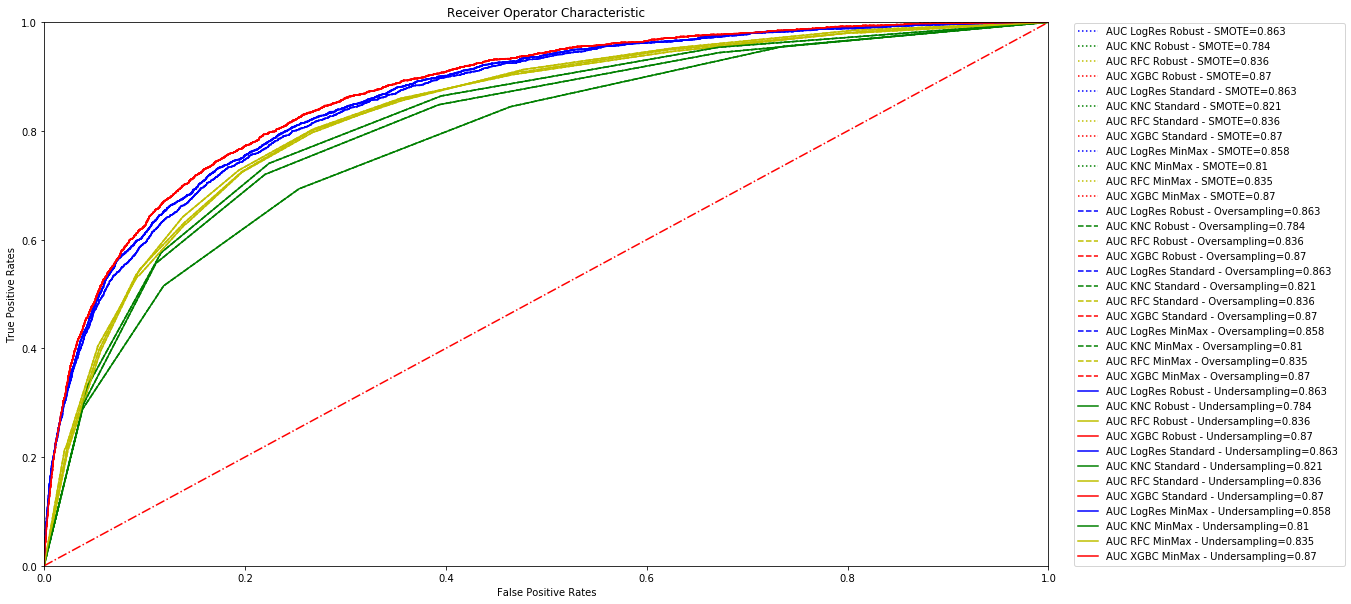

In [104]:
plt.figure(figsize=(18,10))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b:', label=f'AUC LogRes Robust - SMOTE={sc1} ')
plt.plot(fpr2, tpr2, 'g:', label=f'AUC KNC Robust - SMOTE={sc2} ')
plt.plot(fpr3, tpr3, 'y:', label=f'AUC RFC Robust - SMOTE={sc3} ')
plt.plot(fpr4, tpr4, 'r:', label=f'AUC XGBC Robust - SMOTE={sc4} ')
plt.plot(fpr5, tpr5, 'b:', label=f'AUC LogRes Standard - SMOTE={sc5} ')
plt.plot(fpr6, tpr6, 'g:', label=f'AUC KNC Standard - SMOTE={sc6} ')
plt.plot(fpr7, tpr7, 'y:', label=f'AUC RFC Standard - SMOTE={sc7} ')
plt.plot(fpr8, tpr8, 'r:', label=f'AUC XGBC Standard - SMOTE={sc8} ')
plt.plot(fpr9, tpr9, 'b:', label=f'AUC LogRes MinMax - SMOTE={sc9} ')
plt.plot(fpr10, tpr10, 'g:', label=f'AUC KNC MinMax - SMOTE={sc10} ')
plt.plot(fpr11, tpr11, 'y:', label=f'AUC RFC MinMax - SMOTE={sc11} ')
plt.plot(fpr12, tpr12, 'r:', label=f'AUC XGBC MinMax - SMOTE={sc12} ')
plt.plot(fpr13, tpr13, 'b--', label=f'AUC LogRes Robust - Oversampling={sc13} ')
plt.plot(fpr14, tpr14, 'g--', label=f'AUC KNC Robust - Oversampling={sc14} ')
plt.plot(fpr15, tpr15, 'y--', label=f'AUC RFC Robust - Oversampling={sc15} ')
plt.plot(fpr16, tpr16, 'r--', label=f'AUC XGBC Robust - Oversampling={sc16} ')
plt.plot(fpr17, tpr17, 'b--', label=f'AUC LogRes Standard - Oversampling={sc17} ')
plt.plot(fpr18, tpr18, 'g--', label=f'AUC KNC Standard - Oversampling={sc18} ')
plt.plot(fpr19, tpr19, 'y--', label=f'AUC RFC Standard - Oversampling={sc19} ')
plt.plot(fpr20, tpr20, 'r--', label=f'AUC XGBC Standard - Oversampling={sc20} ')
plt.plot(fpr21, tpr21, 'b--', label=f'AUC LogRes MinMax - Oversampling={sc21} ')
plt.plot(fpr22, tpr22, 'g--', label=f'AUC KNC MinMax - Oversampling={sc22} ')
plt.plot(fpr23, tpr23, 'y--', label=f'AUC RFC MinMax - Oversampling={sc23} ')
plt.plot(fpr24, tpr24, 'r--', label=f'AUC XGBC MinMax - Oversampling={sc24} ')
plt.plot(fpr25, tpr25, 'b', label=f'AUC LogRes Robust - Undersampling={sc25} ')
plt.plot(fpr26, tpr26, 'g', label=f'AUC KNC Robust - Undersampling={sc26} ')
plt.plot(fpr27, tpr27, 'y', label=f'AUC RFC Robust - Undersampling={sc27} ')
plt.plot(fpr28, tpr28, 'r', label=f'AUC XGBC Robust - Undersampling={sc28} ')
plt.plot(fpr29, tpr29, 'b', label=f'AUC LogRes Standard - Undersampling={sc29} ')
plt.plot(fpr30, tpr30, 'g', label=f'AUC KNC Standard - Undersampling={sc30} ')
plt.plot(fpr31, tpr31, 'y', label=f'AUC RFC Standard - Undersampling={sc31} ')
plt.plot(fpr32, tpr32, 'r', label=f'AUC XGBC Standard - Undersampling={sc32} ')
plt.plot(fpr33, tpr33, 'b', label=f'AUC LogRes MinMax - Undersampling={sc33} ')
plt.plot(fpr34, tpr34, 'g', label=f'AUC KNC MinMax - Undersampling={sc34} ')
plt.plot(fpr35, tpr35, 'y', label=f'AUC RFC MinMax - Undersampling={sc35} ')
plt.plot(fpr36, tpr36, 'r', label=f'AUC XGBC MinMax - Undersampling={sc36} ')


plt.plot([0,1],[0,1],'r-.')

plt.ylim([0,1]) # dizoom grafiknya dari 0.1
plt.xlim([0,1])
plt.legend(bbox_to_anchor=(0.3,0.,1,1),loc=5)
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.show()

In [105]:
list_of_sc=[sc1,sc2,sc3,sc4,sc5,sc6,sc7,sc8,sc9,sc10,sc11,sc12,sc13,sc14,sc15,sc16,sc17,sc18,sc19,sc20,sc21,sc22,sc23,sc24,sc25,sc26,sc27,sc28,sc29,sc30,sc31,sc32,sc33,sc34,sc35,sc36]

In [106]:
list_of_algo=[
    'AUC LogRes Robust - SMOTE','AUC KNC Robust - SMOTE','AUC RFC Robust - SMOTE','AUC XGBC Robust - SMOTE','AUC LogRes Standard - SMOTE','AUC KNC Standard - SMOTE','AUC RFC Standard - SMOTE','AUC XGBC Standard - SMOTE','AUC LogRes MinMax - SMOTE','AUC KNC MinMax - SMOTE','AUC RFC MinMax - SMOTE','AUC XGBC MinMax - SMOTE',
    'AUC LogRes Robust - Oversampling','AUC KNC Robust - Oversampling','AUC RFC Robust - Oversampling','AUC XGBC Robust - Oversampling','AUC LogRes Standard - Oversampling','AUC KNC Standard - Oversampling','AUC RFC Standard - Oversampling','AUC XGBC Standard - Oversampling','AUC LogRes MinMax - Oversampling','AUC KNC MinMax - Oversampling','AUC RFC MinMax - Oversampling','AUC XGBC MinMax - Oversampling',
    'AUC LogRes Robust - Undersampling','AUC KNC Robust - Undersampling','AUC RFC Robust - Undersampling','AUC XGBC Robust - Undersampling','AUC LogRes Standard - Undersampling','AUC KNC Standard - Undersampling','AUC RFC Standard - Undersampling','AUC XGBC Standard - Undersampling','AUC LogRes MinMax - Undersampling','AUC KNC MinMax - Undersampling','AUC RFC MinMax - Undersampling','AUC XGBC MinMax - Undersampling',
]

In [107]:
list_of_accuracy=[akurasi_train1,akurasi_train2,akurasi_train3,akurasi_train4,akurasi_train5,akurasi_train6,akurasi_train7,akurasi_train8,akurasi_train9,akurasi_train10,akurasi_train11,akurasi_train12,akurasi_train13,akurasi_train14,akurasi_train15,akurasi_train16,akurasi_train17,akurasi_train18,akurasi_train19,akurasi_train20,akurasi_train21,akurasi_train22,akurasi_train23,akurasi_train24,akurasi_train25,akurasi_train26,akurasi_train27,akurasi_train28,akurasi_train29,akurasi_train30,akurasi_train31,akurasi_train32,akurasi_train33,akurasi_train34,akurasi_train35,akurasi_train36]

In [108]:
list_of_TP=[TP1,TP2,TP3,TP4,TP5,TP6,TP7,TP8,TP9,TP10,TP11,TP12,TP13,TP14,TP15,TP16,TP17,TP18,TP19,TP20,TP21,TP22,TP23,TP24,TP25,TP26,TP27,TP28,TP29,TP30,TP31,TP32,TP33,TP34,TP35,TP36]
list_of_FP=[FP1,FP2,FP3,FP4,FP5,FP6,FP7,FP8,FP9,FP10,FP11,FP12,FP13,FP14,FP15,FP16,FP17,FP18,FP19,FP20,FP21,FP22,FP23,FP24,FP25,FP26,FP27,FP28,FP29,FP30,FP31,FP32,FP33,FP34,FP35,FP36]
list_of_TN=[TN1,TN2,TN3,TN4,TN5,TN6,TN7,TN8,TN9,TN10,TN11,TN12,TN13,TN14,TN15,TN16,TN17,TN18,TN19,TN20,TN21,TN22,TN23,TN24,TN25,TN26,TN27,TN28,TN29,TN30,TN31,TN32,TN33,TN34,TN35,TN36]
list_of_FN=[FN1,FN2,FN3,FN4,FN5,FN6,FN7,FN8,FN9,FN10,FN11,FN12,FN13,FN14,FN15,FN16,FN17,FN18,FN19,FN20,FN21,FN22,FN23,FN24,FN25,FN26,FN27,FN28,FN29,FN30,FN31,FN32,FN33,FN34,FN35,FN36]

In [109]:
list_of_accuracy = [
    round(accuracy_score(y_test,prediksi1),2),round(accuracy_score(y_test,prediksi2),2),round(accuracy_score(y_test,prediksi3),2),round(accuracy_score(y_test,prediksi4),2),round(accuracy_score(y_test,prediksi5),2),round(accuracy_score(y_test,prediksi6),2),round(accuracy_score(y_test,prediksi7),2),round(accuracy_score(y_test,prediksi8),2),round(accuracy_score(y_test,prediksi9),2),round(accuracy_score(y_test,prediksi10),2),round(accuracy_score(y_test,prediksi11),2),
    round(accuracy_score(y_test,prediksi12),2),round(accuracy_score(y_test,prediksi13),2),round(accuracy_score(y_test,prediksi14),2),round(accuracy_score(y_test,prediksi15),2),round(accuracy_score(y_test,prediksi16),2),round(accuracy_score(y_test,prediksi17),2),round(accuracy_score(y_test,prediksi18),2),round(accuracy_score(y_test,prediksi19),2),round(accuracy_score(y_test,prediksi20),2),round(accuracy_score(y_test,prediksi21),2),round(accuracy_score(y_test,prediksi22),2),
    round(accuracy_score(y_test,prediksi23),2),round(accuracy_score(y_test,prediksi24),2),round(accuracy_score(y_test,prediksi25),2),round(accuracy_score(y_test,prediksi26),2),round(accuracy_score(y_test,prediksi27),2),round(accuracy_score(y_test,prediksi28),2),round(accuracy_score(y_test,prediksi29),2),round(accuracy_score(y_test,prediksi30),2),round(accuracy_score(y_test,prediksi31),2),round(accuracy_score(y_test,prediksi32),2),round(accuracy_score(y_test,prediksi33),2),
    round(accuracy_score(y_test,prediksi34),2),round(accuracy_score(y_test,prediksi35),2),round(accuracy_score(y_test,prediksi36),2)
]

list_of_precision = [
    round(precision_score(y_test,prediksi1),2),round(precision_score(y_test,prediksi2),2),round(precision_score(y_test,prediksi3),2),round(precision_score(y_test,prediksi4),2),round(precision_score(y_test,prediksi5),2),round(precision_score(y_test,prediksi6),2),round(precision_score(y_test,prediksi7),2),round(precision_score(y_test,prediksi8),2),round(precision_score(y_test,prediksi9),2),round(precision_score(y_test,prediksi10),2),round(precision_score(y_test,prediksi11),2),
    round(precision_score(y_test,prediksi12),2),round(precision_score(y_test,prediksi13),2),round(precision_score(y_test,prediksi14),2),round(precision_score(y_test,prediksi15),2),round(precision_score(y_test,prediksi16),2),round(precision_score(y_test,prediksi17),2),round(precision_score(y_test,prediksi18),2),round(precision_score(y_test,prediksi19),2),round(precision_score(y_test,prediksi20),2),round(precision_score(y_test,prediksi21),2),round(precision_score(y_test,prediksi22),2),
    round(precision_score(y_test,prediksi23),2),round(precision_score(y_test,prediksi24),2),round(precision_score(y_test,prediksi25),2),round(precision_score(y_test,prediksi26),2),round(precision_score(y_test,prediksi27),2),round(precision_score(y_test,prediksi28),2),round(precision_score(y_test,prediksi29),2),round(precision_score(y_test,prediksi30),2),round(precision_score(y_test,prediksi31),2),round(precision_score(y_test,prediksi32),2),round(precision_score(y_test,prediksi33),2),
    round(precision_score(y_test,prediksi34),2),round(precision_score(y_test,prediksi35),2),round(precision_score(y_test,prediksi36),2)
]


list_of_recall = [
    round(recall_score(y_test,prediksi1),2),round(recall_score(y_test,prediksi2),2),round(recall_score(y_test,prediksi3),2),round(recall_score(y_test,prediksi4),2),round(recall_score(y_test,prediksi5),2),round(recall_score(y_test,prediksi6),2),round(recall_score(y_test,prediksi7),2),round(recall_score(y_test,prediksi8),2),round(recall_score(y_test,prediksi9),2),round(recall_score(y_test,prediksi10),2),round(recall_score(y_test,prediksi11),2),
    round(recall_score(y_test,prediksi12),2),round(recall_score(y_test,prediksi13),2),round(recall_score(y_test,prediksi14),2),round(recall_score(y_test,prediksi15),2),round(recall_score(y_test,prediksi16),2),round(recall_score(y_test,prediksi17),2),round(recall_score(y_test,prediksi18),2),round(recall_score(y_test,prediksi19),2),round(recall_score(y_test,prediksi20),2),round(recall_score(y_test,prediksi21),2),round(recall_score(y_test,prediksi22),2),
    round(recall_score(y_test,prediksi23),2),round(recall_score(y_test,prediksi24),2),round(recall_score(y_test,prediksi25),2),round(recall_score(y_test,prediksi26),2),round(recall_score(y_test,prediksi27),2),round(recall_score(y_test,prediksi28),2),round(recall_score(y_test,prediksi29),2),round(recall_score(y_test,prediksi30),2),round(recall_score(y_test,prediksi31),2),round(recall_score(y_test,prediksi32),2),round(recall_score(y_test,prediksi33),2),
    round(recall_score(y_test,prediksi34),2),round(recall_score(y_test,prediksi35),2),round(recall_score(y_test,prediksi36),2)
]

In [110]:
zipped = list(zip(list_of_algo,list_of_sc,list_of_TP,list_of_FP,list_of_TN,list_of_FN,list_of_accuracy,list_of_precision,list_of_recall))
df_AUC = pd.DataFrame(zipped,columns=['Nama Algoritma & Metoda Imbalance Handling','Nilai AUC','True Positive','False Positive','True Negative','False Negative','Accuracy','Precision','Recall'])

In [111]:
df_AUC.sort_values(by=['Nilai AUC','Recall','False Positive'],ascending=False) # urutannya berdasarkan AUC, Recall, dan jumlah False Positive

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Accuracy,Precision,Recall
3,AUC XGBC Robust - SMOTE,0.870,1882,7329,27502,529,0.79,0.20,0.78
11,AUC XGBC MinMax - SMOTE,0.870,1882,7329,27502,529,0.79,0.20,0.78
15,AUC XGBC Robust - Oversampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
23,AUC XGBC MinMax - Oversampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
27,AUC XGBC Robust - Undersampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
35,AUC XGBC MinMax - Undersampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
7,AUC XGBC Standard - SMOTE,0.870,1882,7328,27503,529,0.79,0.20,0.78
19,AUC XGBC Standard - Oversampling,0.870,1882,7328,27503,529,0.79,0.20,0.78
31,AUC XGBC Standard - Undersampling,0.870,1882,7328,27503,529,0.79,0.20,0.78
0,AUC LogRes Robust - SMOTE,0.863,1809,6893,27938,602,0.80,0.21,0.75


Diperoleh XGBC-Robust SMOTE yang memiliki performa terbaik dengan parameter algoritma default

# Hyper Tuning

Hyper Tuning merupakan proses yang sangat memakan waktu , oleh karena itu akan dipilih 4 algoritma yang berbeda-beda dan memiliki performa terbaik yaitu : 

- XGBC Robust SMOTE
- Random Forest Classifier Robust SMOTE
- K Nearest Neighbors Robust SMOTE
- Logistic Regression Robust SMOTE

## Logisic Regression Tuning

In [58]:
pipeline1 = Pipeline([
    ("scaler", RobustScaler()),
    ("logres", LogisticRegression())
])
params1 = {
    "logres__tol":np.logspace(-4,0,5), # semakin besar akan overfit, default 0.0001
    "logres__C":np.linspace(1,2,3), # semakin besar akan overfit, default 1
    "logres__max_iter":[100,500,1000], # semakin besar akan underfit, default 100 
}

## Hyper Parameter Tuning Model 

In [59]:
model1 = RandomizedSearchCV(pipeline1, params1, n_iter=100, cv=3, n_jobs=-1, verbose=10, random_state=42)

In [60]:
model1.fit(X_train_sm,y_train_sm)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   52.8s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              RobustScaler(copy=True,
                                                           quantile_range=(25.0,
                                                                           75.0),
                                                           with_centering=True,
                                                           with_scaling=True)),
                                             ('logres',
                                              LogisticRegression(C=1.0,
                                                                 class_weight=None,
                                                                 dual=False,
                                                                 fit_intercept=True,
                                                                 int

In [61]:
model1.best_params_

{'logres__tol': 0.0001, 'logres__max_iter': 100, 'logres__C': 1.5}

In [62]:
model1.score(X_test,y_test)

0.8170076795016379

In [63]:
prediksi1 = model1.predict(X_test)

In [64]:
print(classification_report(y_test,prediksi1))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     34831
           1       0.22      0.73      0.34      2411

    accuracy                           0.82     37242
   macro avg       0.60      0.78      0.62     37242
weighted avg       0.93      0.82      0.86     37242



In [65]:
cm = confusion_matrix(y_test,prediksi1,labels=[1,0])
print(cm)

[[ 1769   642]
 [ 6173 28658]]


In [66]:
TP1,FN1,FP1,TN1 = cm[0,0],cm[0,1],cm[1,0],cm[1,1]

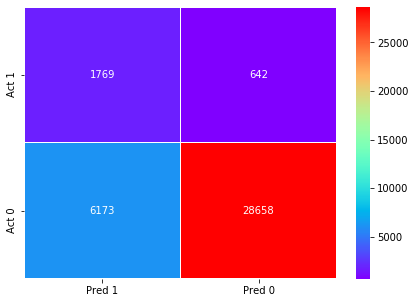

In [67]:
df_cm = pd.DataFrame(cm,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])

plt.figure(figsize=(7,5))
x = sns.heatmap(df_cm, annot=True,annot_kws={'size':10},fmt='d',linewidths=0.2,cmap='rainbow')
x.set_ylim(2,0)
plt.show()

## ROC-AUC Curve

In [68]:
proba1 = model1.predict_proba(X_test)

In [69]:
pred1 = proba1[:,1] 
fpr1, tpr1, threshold1 = roc_curve(y_test, pred1)

In [70]:
sc1 = round(auc(fpr1,tpr1),3)

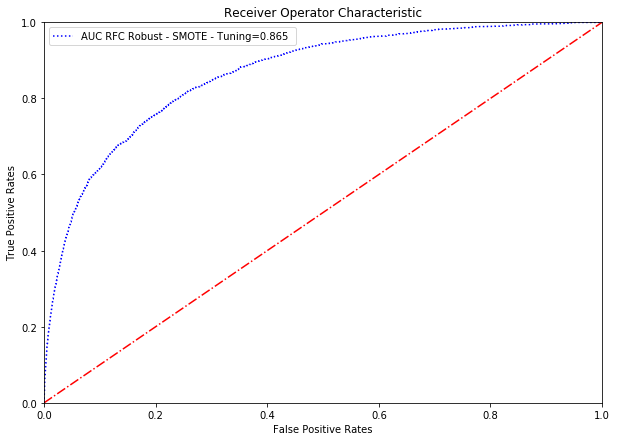

In [71]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b:', label=f'AUC RFC Robust - SMOTE - Tuning={sc1} ')

plt.plot([0,1],[0,1],'r-.')

plt.ylim([0,1]) # dizoom grafiknya dari 0.1
plt.xlim([0,1])
plt.legend()
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.show()

In [72]:
list_of_sc=[sc1]

In [73]:
list_of_algo=[
    'AUC RFC Robust - SMOTE'
]

In [74]:
list_of_TP=[TP1]
list_of_FP=[FP1]
list_of_TN=[TN1]
list_of_FN=[FN1]

In [75]:
accuracy = [round(accuracy_score(y_test,prediksi1),2)]
precision = [round(precision_score(y_test,prediksi1),2)]
recall = [round(recall_score(y_test,prediksi1),2)]

In [76]:
zipped = list(zip(list_of_algo,list_of_sc,list_of_TP,list_of_FP,list_of_TN,list_of_FN,accuracy,precision,recall))
df_AUC = pd.DataFrame(zipped,columns=['Nama Algoritma & Metoda Imbalance Handling','Nilai AUC','True Positive','False Positive','True Negative','False Negative','Akurasi','Precision','Recall'])

In [77]:
df_AUC.sort_values(by='Nilai AUC',ascending=False)

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Akurasi,Precision,Recall
0,AUC RFC Robust - SMOTE,0.865,1769,6173,28658,642,0.82,0.22,0.73


## K Nearest Neighbors Tuning

In [58]:
pipeline1 = Pipeline([
    ("scaler", RobustScaler()),
    ("knc", KNeighborsClassifier())
])
params1 = {
    "knc__n_neighbors":np.arange(1,11,2), # semakin besar akan underfit, default 5
    "knc__leaf_size":[30,40,50], # semakin besar akan overfit, default 30
    "knc__p":[1,2], # 1 sama dengan menggunakan manhattan distance, 2 sama dengan menggunakan euclidean distance, default 2
}

## Hyper Parameter Tuning Model 

In [59]:
model1 = RandomizedSearchCV(pipeline1, params1, n_iter=100, cv=3, n_jobs=-1, verbose=10, random_state=42)

In [60]:
model1.fit(X_train_sm,y_train_sm)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 25.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 30.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              RobustScaler(copy=True,
                                                           quantile_range=(25.0,
                                                                           75.0),
                                                           with_centering=True,
                                                           with_scaling=True)),
                                             ('knc',
                                              KNeighborsClassifier(algorithm='auto',
                                                                   leaf_size=30,
                                                                   metric='minkowski',
                                                                   metric_params=None,
                                                 

In [61]:
model1.best_params_

{'knc__p': 1, 'knc__n_neighbors': 1, 'knc__leaf_size': 30}

In [62]:
model1.score(X_test,y_test)

0.8852908007088771

In [63]:
prediksi1 = model1.predict(X_test)

In [64]:
print(classification_report(y_test,prediksi1))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94     34831
           1       0.22      0.31      0.26      2411

    accuracy                           0.89     37242
   macro avg       0.59      0.62      0.60     37242
weighted avg       0.90      0.89      0.89     37242



In [65]:
cm = confusion_matrix(y_test,prediksi1,labels=[1,0])
print(cm)

[[  755  1656]
 [ 2616 32215]]


In [66]:
TP1,FN1,FP1,TN1 = cm[0,0],cm[0,1],cm[1,0],cm[1,1]

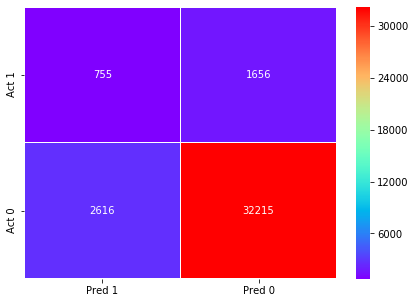

In [67]:
df_cm = pd.DataFrame(cm,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])

plt.figure(figsize=(7,5))
x = sns.heatmap(df_cm, annot=True,annot_kws={'size':10},fmt='d',linewidths=0.2,cmap='rainbow')
x.set_ylim(2,0)
plt.show()

## ROC-AUC Curve

In [68]:
proba1 = model1.predict_proba(X_test)

In [69]:
pred1 = proba1[:,1] 
fpr1, tpr1, threshold1 = roc_curve(y_test, pred1)

In [70]:
sc1 = round(auc(fpr1,tpr1),3)

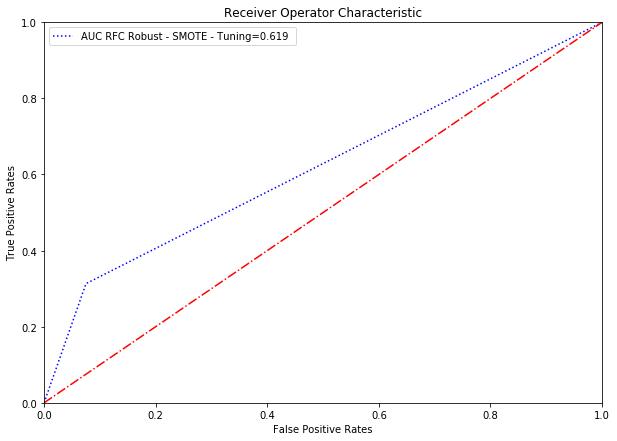

In [71]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b:', label=f'AUC RFC Robust - SMOTE - Tuning={sc1} ')

plt.plot([0,1],[0,1],'r-.')

plt.ylim([0,1]) # dizoom grafiknya dari 0.1
plt.xlim([0,1])
plt.legend()
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.show()

In [72]:
list_of_sc=[sc1]

In [73]:
list_of_algo=[
    'AUC RFC Robust - SMOTE'
]

In [74]:
list_of_TP=[TP1]
list_of_FP=[FP1]
list_of_TN=[TN1]
list_of_FN=[FN1]

In [75]:
accuracy = [round(accuracy_score(y_test,prediksi1),2)]
precision = [round(precision_score(y_test,prediksi1),2)]
recall = [round(recall_score(y_test,prediksi1),2)]

In [76]:
zipped = list(zip(list_of_algo,list_of_sc,list_of_TP,list_of_FP,list_of_TN,list_of_FN,accuracy,precision,recall))
df_AUC = pd.DataFrame(zipped,columns=['Nama Algoritma & Metoda Imbalance Handling','Nilai AUC','True Positive','False Positive','True Negative','False Negative','Akurasi','Precision','Recall'])

In [77]:
df_AUC.sort_values(by='Nilai AUC',ascending=False)

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Akurasi,Precision,Recall
0,AUC RFC Robust - SMOTE,0.619,755,2616,32215,1656,0.89,0.22,0.31


## XGBoost Classifier Tuning

In [70]:
pipeline1 = Pipeline([
    ("scaler", RobustScaler()),
    ("xgbc", XGBClassifier())
])
params1 = {
    "xgbc__max_depth":[3,10], # semakin besar akan overfit, default 3
    "xgbc__learning_rate":np.logspace(-3,-1,5), # semakin besar akan underfit, default 0.1
    "xgbc__n_estimators":[100,500,1000], # semakin besar akan overfit, default 100
    "xgbc__min_child_weight":[1,5], # berfungsi untuk regularisasi, default 1 
}

## Hyper Parameter Tuning Model 

In [71]:
model1 = RandomizedSearchCV(pipeline1, params1, n_iter=100, cv=3, n_jobs=-1, verbose=5, random_state=42)

In [72]:
model1.fit(X_train_sm,y_train_sm)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 169.0min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 204.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              RobustScaler(copy=True,
                                                           quantile_range=(25.0,
                                                                           75.0),
                                                           with_centering=True,
                                                           with_scaling=True)),
                                             ('xgbc',
                                              XGBClassifier(base_score=0.5,
                                                            booster='gbtree',
                                                            colsample_bylevel=1,
                                                            colsample_bynode=1,
                                                            colsample_byt

In [74]:
model1.best_params_

{'xgbc__n_estimators': 1000,
 'xgbc__min_child_weight': 1,
 'xgbc__max_depth': 10,
 'xgbc__learning_rate': 0.03162277660168379}

In [86]:
model1.score(X_test,y_test)

0.9371140110627786

In [87]:
prediksi1 = model1.predict(X_test)

In [91]:
print(classification_report(y_test,prediksi1))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     34831
           1       0.54      0.19      0.28      2411

    accuracy                           0.94     37242
   macro avg       0.74      0.59      0.63     37242
weighted avg       0.92      0.94      0.92     37242



In [90]:
cm = confusion_matrix(y_test,prediksi1,labels=[1,0])
print(cm)

[[  466  1945]
 [  397 34434]]


In [102]:
TP1,FN1,FP1,TN1 = cm[0,0],cm[0,1],cm[1,0],cm[1,1]

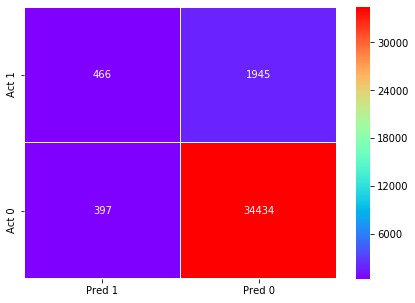

In [103]:
df_cm = pd.DataFrame(cm,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])

plt.figure(figsize=(7,5))
x = sns.heatmap(df_cm, annot=True,annot_kws={'size':10},fmt='d',linewidths=0.2,cmap='rainbow')
x.set_ylim(2,0)
plt.show()

## ROC-AUC Curve

In [75]:
proba1 = model1.predict_proba(X_test)

In [76]:
pred1 = proba1[:,1] 
fpr1, tpr1, threshold1 = roc_curve(y_test, pred1)

In [78]:
sc1 = round(auc(fpr1,tpr1),3)

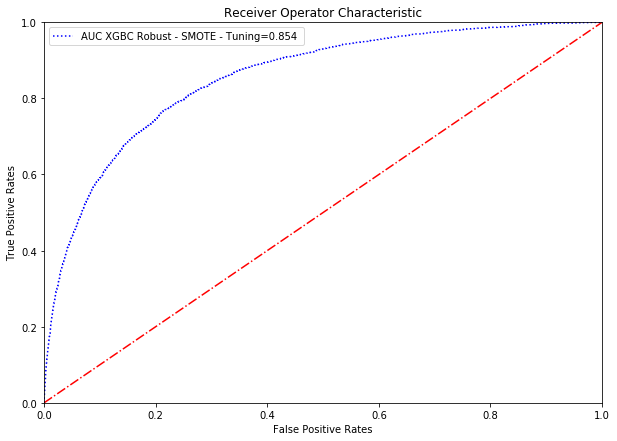

In [82]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b:', label=f'AUC XGBC Robust - SMOTE - Tuning={sc1} ')

plt.plot([0,1],[0,1],'r-.')

plt.ylim([0,1]) # dizoom grafiknya dari 0.1
plt.xlim([0,1])
plt.legend()
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.show()

In [92]:
list_of_sc=[sc1]

In [93]:
list_of_algo=[
    'AUC XGBC Robust - SMOTE'
]

In [104]:
list_of_TP=[TP1]
list_of_FP=[FP1]
list_of_TN=[TN1]
list_of_FN=[FN1]

In [123]:
accuracy = [round(accuracy_score(y_test,prediksi1),2)]
precision = [round(precision_score(y_test,prediksi1),2)]
recall = [round(recall_score(y_test,prediksi1),2)]

In [124]:
zipped = list(zip(list_of_algo,list_of_sc,list_of_TP,list_of_FP,list_of_TN,list_of_FN,accuracy,precision,recall))
df_AUC = pd.DataFrame(zipped,columns=['Nama Algoritma & Metoda Imbalance Handling','Nilai AUC','True Positive','False Positive','True Negative','False Negative','Akurasi','Precision','Recall'])

In [125]:
df_AUC.sort_values(by='Nilai AUC',ascending=False)

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Akurasi,Precision,Recall
0,AUC XGBC Robust - SMOTE,0.854,466,397,34434,1945,0.94,0.54,0.19


## Random Forest Classifier Tuning

In [58]:
pipeline1 = Pipeline([
    ("scaler", RobustScaler()),
    ("rfc", RandomForestClassifier())
])
params1 = {
    "rfc__max_depth":[None,3,10], # semakin besar akan overfit, default None
    "rfc__n_estimators":[100,1000,1500], # semakin besar akan overfit, default 100
    "rfc__min_samples_leaf":[1,7], # semakin besar akan underfit, default 1
    "rfc__min_samples_split":[2,10] # semakin besar akan underfit, default 2  
}

## Hyper Parameter Tuning Model 

In [59]:
model1 = RandomizedSearchCV(pipeline1, params1, n_iter=100, cv=3, n_jobs=-1, verbose=10, random_state=42)

In [60]:
model1.fit(X_train_sm,y_train_sm)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed: 45.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 66.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 86.3min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 98.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 106.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 117.6min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 134.7min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 157.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 193.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              RobustScaler(copy=True,
                                                           quantile_range=(25.0,
                                                                           75.0),
                                                           with_centering=True,
                                                           with_scaling=True)),
                                             ('rfc',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                                                     criterion='gini',
                                                                     max_depth=None,
                                            

In [61]:
model1.best_params_

{'rfc__n_estimators': 1000,
 'rfc__min_samples_split': 2,
 'rfc__min_samples_leaf': 1,
 'rfc__max_depth': None}

In [62]:
model1.score(X_test,y_test)

0.9366843885935234

In [63]:
prediksi1 = model1.predict(X_test)

In [64]:
print(classification_report(y_test,prediksi1))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     34831
           1       0.52      0.24      0.33      2411

    accuracy                           0.94     37242
   macro avg       0.74      0.61      0.65     37242
weighted avg       0.92      0.94      0.93     37242



In [65]:
cm = confusion_matrix(y_test,prediksi1,labels=[1,0])
print(cm)

[[  581  1830]
 [  528 34303]]


In [66]:
TP1,FN1,FP1,TN1 = cm[0,0],cm[0,1],cm[1,0],cm[1,1]

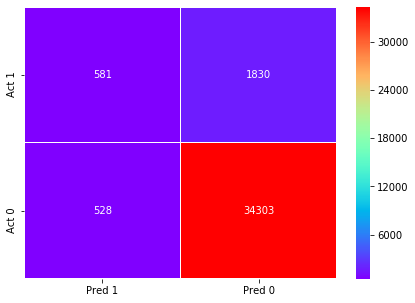

In [67]:
df_cm = pd.DataFrame(cm,columns=['Pred 1', 'Pred 0'],index=['Act 1', 'Act 0'])

plt.figure(figsize=(7,5))
x = sns.heatmap(df_cm, annot=True,annot_kws={'size':10},fmt='d',linewidths=0.2,cmap='rainbow')
x.set_ylim(2,0)
plt.show()

## ROC-AUC Curve

In [68]:
proba1 = model1.predict_proba(X_test)

In [69]:
pred1 = proba1[:,1] 
fpr1, tpr1, threshold1 = roc_curve(y_test, pred1)

In [70]:
sc1 = round(auc(fpr1,tpr1),3)

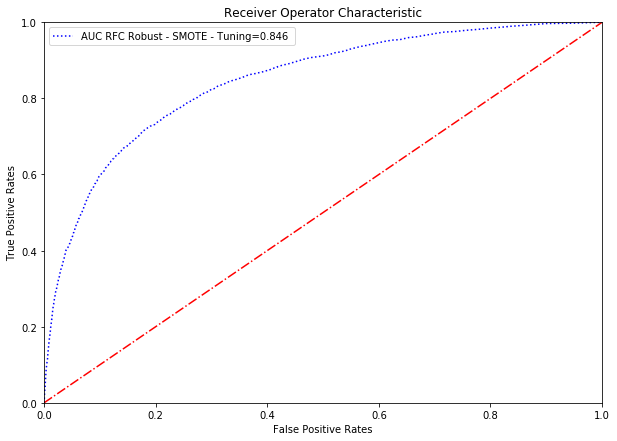

In [71]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr1, tpr1, 'b:', label=f'AUC RFC Robust - SMOTE - Tuning={sc1} ')

plt.plot([0,1],[0,1],'r-.')

plt.ylim([0,1]) # dizoom grafiknya dari 0.1
plt.xlim([0,1])
plt.legend()
plt.xlabel('False Positive Rates')
plt.ylabel('True Positive Rates')
plt.show()

In [72]:
list_of_sc=[sc1]

In [73]:
list_of_algo=[
    'AUC RFC Robust - SMOTE'
]

In [74]:
list_of_TP=[TP1]
list_of_FP=[FP1]
list_of_TN=[TN1]
list_of_FN=[FN1]

In [75]:
accuracy = [round(accuracy_score(y_test,prediksi1),2)]
precision = [round(precision_score(y_test,prediksi1),2)]
recall = [round(recall_score(y_test,prediksi1),2)]

In [76]:
zipped = list(zip(list_of_algo,list_of_sc,list_of_TP,list_of_FP,list_of_TN,list_of_FN,accuracy,precision,recall))
df_AUC = pd.DataFrame(zipped,columns=['Nama Algoritma & Metoda Imbalance Handling','Nilai AUC','True Positive','False Positive','True Negative','False Negative','Akurasi','Precision','Recall'])

In [77]:
df_AUC.sort_values(by='Nilai AUC',ascending=False)

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Akurasi,Precision,Recall
0,AUC RFC Robust - SMOTE,0.846,581,528,34303,1830,0.94,0.52,0.24


# Comparing Model

In [125]:
df_AUC.sort_values(by='Nilai AUC',ascending=False)

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Akurasi,Precision,Recall
0,AUC XGBC Robust - SMOTE,0.854,466,397,34434,1945,0.94,0.54,0.19


In [111]:
df_AUC.sort_values(by=['Nilai AUC','Recall','False Positive'],ascending=False) # urutannya berdasarkan AUC, Recall, dan jumlah False Positive

,Nama Algoritma & Metoda Imbalance Handling,Nilai AUC,True Positive,False Positive,True Negative,False Negative,Accuracy,Precision,Recall
3,AUC XGBC Robust - SMOTE,0.870,1882,7329,27502,529,0.79,0.20,0.78
11,AUC XGBC MinMax - SMOTE,0.870,1882,7329,27502,529,0.79,0.20,0.78
15,AUC XGBC Robust - Oversampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
23,AUC XGBC MinMax - Oversampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
27,AUC XGBC Robust - Undersampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
35,AUC XGBC MinMax - Undersampling,0.870,1882,7329,27502,529,0.79,0.20,0.78
7,AUC XGBC Standard - SMOTE,0.870,1882,7328,27503,529,0.79,0.20,0.78
19,AUC XGBC Standard - Oversampling,0.870,1882,7328,27503,529,0.79,0.20,0.78
31,AUC XGBC Standard - Undersampling,0.870,1882,7328,27503,529,0.79,0.20,0.78
0,AUC LogRes Robust - SMOTE,0.863,1809,6893,27938,602,0.80,0.21,0.75


Performa terbaik terdapat pada XGBoost Classifier dengan default parameter <br>

Nilai AUC pada XGBC Hyper Tuning dibawah AUC dengan parameter default, hal ini disebabkan oleh teknik RandomizedSearch pada pencarian parameternya. Pencarian parameter menggunakan GridSearch akan mengimprove hal ini namun akan dibutuhkan waktu yang sangat lama dalam pemodelannya. Model terbaik akan dipilih melalui f1 scorenya yaitu XGBC dengan <b>default parameter</b>

 - Hal utama yang menjadi validasi model adalah nilai AUC ROC model diatas 0.84
 - False Positive lebih ditolerir daripada False Negative, hal ini terdasari oleh business objective dimana customer yang mengalami default dan salah diprediksi oleh model (menjadi tidak default) akan menimbulkan kerugian bagi bank / pengguna model. Sementara kesalahan model dalam memprediksi customer yang default padahal tidak, lebih berakibat kepada berkurangnya keuntungan bukan kerugian bagi bank / pengguna model
 - Selain nilai AUC ROC, hal kedua yang menjadi faktor pemilihan model terbaik adalah nilai precision (untuk customer yang mengalami default). Semakin tinggi nilainya maka akan didapat model yang dapat memperoleh nilai False Positive dan False Negative yang kecil. Hal ini akan berakibat pada mengecilnya kerugian bank / pengguna model karena salah prediksi customer yang tidak default (padahal default / False Negative) dan memperbesar kesempatan bank / pengguna model untuk memperoleh keuntungan sebesar – besarnya karena dapat memprediksi customer yang default dengan tepat (padahal tidak / False Positive)


# Export Model

In [1]:
# with open ('ModelFinal.sav', 'wb') as model:
#     pickle.dump(model4, model)
# di commend agar tidak create double

# Klasifikasi Kelompok Resiko 

In [50]:
# Memprediksi semua data berdasarkan model
all_data = X.drop(['binned_age'],axis=1)
prediksi_all = model4.predict_proba(all_data)

In [51]:
pred_all = prediksi_all[:,1].tolist()
all_data['Probability'] = pred_all

In [52]:
len(pred_all)

148967

In [53]:
ind = [i for i in range(1,148968)]

In [67]:
all_data['Target'] = df_training['SeriousDlqin2yrs']

In [68]:
all_data.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Probability,riskCategory,Target
index,,,,,,,,,,,,,
1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,0.346163,Good,1
2,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0.051507,Exceptional,0
3,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0.158247,Very Good,0
4,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0.024187,Exceptional,0
5,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0.041691,Exceptional,0


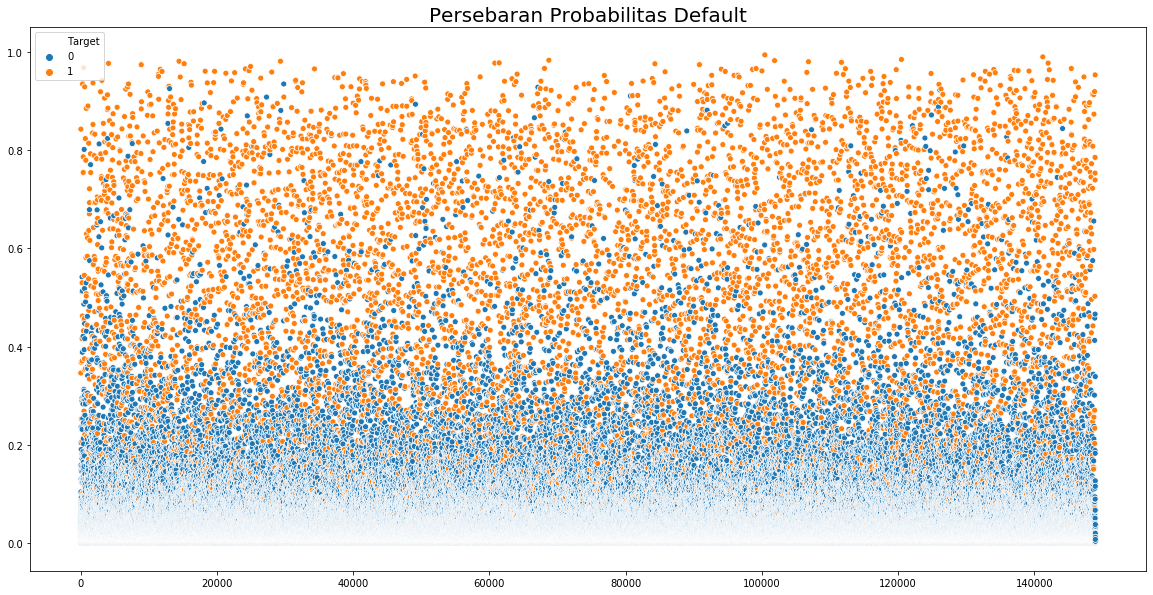

In [69]:
plt.figure(figsize=(20,10))
plt.title('Persebaran Probabilitas Default',size=20)
sns.scatterplot(x=ind,y=pred_all,hue='Target',data=all_data)
plt.show()

In [96]:
pd.crosstab(index=all_data.Target, columns=all_data.Target, values=all_data.Probability, aggfunc=['max','min'])

max                 min          
Target         0         1         0         1
Target                                        
0       0.934106       NaN  0.000178       NaN
1            NaN  0.993244       NaN  0.000561

Dapat dilihat bahwa nilai minimum probability dimana customer default adalah 0.000561. Nilai ini akan dijadikan batas atas customer yang masuk dalam kelompok resiko Exceptional.
Nilai maksimum probability dimana customer default adalah 0.993244. Nilai ini akan dijadikan batas atas probability customer yang masuk dalam kelompok resiko Poor.
Selanjutnya data akan dibagi menjadi 5 kelompok dengan interval probability yang sama.

Probability akan dibagi menjadi 5 kelompok resiko yaitu : 

1. Exceptional 
2. Very Good 
3. Good 
4. Fair 
5. Poor 

Kelima kelompok resiko ini akan ditentukan berdasarkan probabilitasnya dimana <b>semakin tinggi probabilitas default akan semakin rendah tingkatan angkanya (menuju kelompok poor)</b>

## Binning

In [90]:
# Binning probabilty by interval 0.2
x = (0.993245 - 0.000561)/2 # batas tengah
y = x / 2
bins = [-1,0.000562,y,x,x+y,1] # binning dengan interval 0.2 
label = ['Exceptional','Very Good','Good','Fair','Poor'] # label kelompok resiko
all_data['riskCategory']=pd.cut(all_data['Probability'],bins=bins,labels=label)

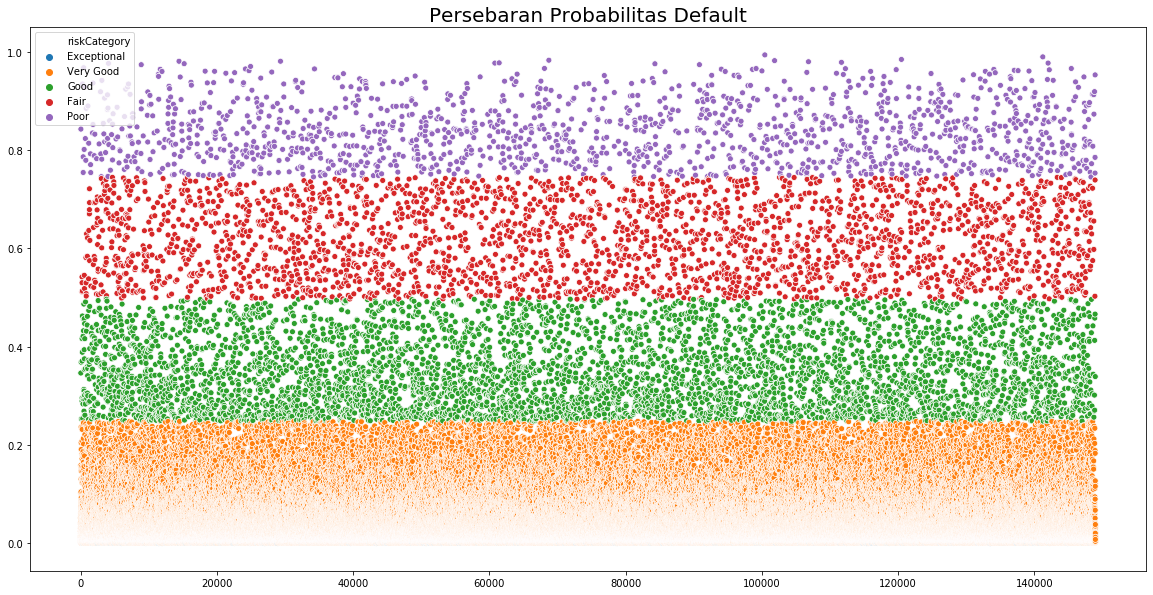

In [91]:
plt.figure(figsize=(20,10))
plt.title('Persebaran Probabilitas Default',size=20)
sns.scatterplot(x=ind,y=pred_all,hue='riskCategory',data=all_data)
plt.legend()
plt.show()

In [92]:
all_data['riskCategory'].value_counts()

Very Good      139667
Good             5017
Fair             2628
Poor             1471
Exceptional       184
Name: riskCategory, dtype: int64

In [93]:
print("Persentase Exceptional :",184/len(all_data))
print("Persentase Very Good :",139667/len(all_data))
print("Persentase Good :",5017/len(all_data))
print("Persentase Fair :",2628/len(all_data))
print("Persentase Poor :",1471/len(all_data))

Persentase Exceptional : 0.0012351728906402088
Persentase Very Good : 0.9375700658535112
Persentase Good : 0.033678599958380045
Persentase Fair : 0.01764149106849168
Persentase Poor : 0.009874670228976888


Dapat dilihat bahwa data yang exceptional bila dibandingkan dengan kelompok resiko yang lain memiliki jumlah yang timpang / tidak seimbang, sehingga untuk kategori exceptional akan diberikan penalty sebanyak 0.2 poin untuk probabilitynya. Poin ini kemudian akan diberikan kepada kelompok resiko "Poor". Pemberian poin ini adalah <b>subjektif</b>, hasil pengamatan penulis selain itu pemberian poin ini menjadikan kelompok resiko Poor memiliki range yang lebih besar dan menjadikan scoring lebih ketat.

In [95]:
print(x)
print(y)
print(x+y)

0.496342
0.248171
0.744513


Kelompok resiko berdasarkan probability adalah : 

1. Exceptional   (proba : 0 - 0.000561) 
2. Very Good     (proba : 0.000561 - 0.248171)
3. Good          (proba : 0.248172 - 0.496342)
4. Fair          (proba : 0.496343 - 0.744513)
5. Poor          (proba : 0.744514 - 0.993245)

# Kesimpulan dan Saran

 <b> Goals </b>

   - Pemodelan yang dapat memprediksi default dengan target AUC ROC > 0.84
   - Pengelompokkan customer berdasarkan default probability  menjadi 5 tingkatan yaitu poor, fair, good, very good dan exceptional (mirip dengan yang ada pada FICO score)
   - Analisa setiap features pada dataset dan hubungan dengan tingkat default customer


<b>Kesimpulan</b>

- Diperoleh pemodelan dengan AUC ROC sebesar 0.87, algoritma yang digunakan adalah XGBoost Classifier dengan default parameter <br>
- Pengelompokkan data menjadi 5 kelompok resiko yaitu poor, fair, good, very good dan exceptional dengan interval probabilitas sebagai berikut :
    1. Exceptional  (proba : 0 - 0.000561) 
    2. Very Good    (proba : 0.000561 - 0.248171)
    3. Good         (proba : 0.248172 - 0.496342)
    4. Fair         (proba : 0.496343 - 0.744513)
    5. Poor         (proba : 0.744514 -1)
- Customer yang mengalami default memiliki median RevolvingUtilizationOfUnsecuredlines sebesar 83%, sementara yang tidak mengalami default memiliki median RevolvingUtilizationOfUnsecuredlines sebesar 13.3%. 
- Dari hasil pengelompokkan dapat dilihat bahwa kelompok usia 41-50 tahun paling banyak mengalami gagal bayar dengan persentase 19.1% terhadap keseluruhan data
- Kelompok customer dengan nilai NumberOfTime30-59DaysPastDueNotWorse 0-3 merupakan yang paling banyak mengalami default
- Kelompok customer dengan nilai DebtRatio 0-2 merupakan kelompok customer yang paling banyak mengalami gagal bayar yaitu sebanyak 5.5% dari keseluruhan data
- Kelompok customer dengan NumberOfOpenCreditLinesAndLoans 0-10 memiliki jumlah default paling banyak yaitu 5.1%
- Setelah dikelompokkan, customer dengan nilai NT90 0-3 memiliki jumlah default paling banyak yaitu 6.4%
- Setelah pengelompokkan customer dengan nilai NRELL 0-10 memiiki jumlah customer yang paling banyak mengalami default yaitu 6.67%
- Pada features ini kelompok customer dengan nilai NT6089 0-3 yang memiliki jumlah default paling banyak yaitu sebesar 6.5%
- Kelompok customer dengan nilai ND 0-5 memiliki jumlah default paling banyak yaitu 6.7%.
- Korelasi positif terkuat terhadap target terdapat pada features NumberOfTime30-59DaysPastDueNotWorse yaitu sebesar 0.13. Selain itu kekuatan korelasi yang sama ditemukan juga pada features NumberOfTimes90DaysLate sebesar 0.12 dan NumberOfTime60-89DaysPastDueNotWorse sebesar 1. Dari hal ini dapat disimpulkan bahwa adanya keterlambatan pembayaran kredit memiliki korelasi yang kuat dengan customer yang default
- Korelasi negatif terkuat terhadap terget terdapat pada features age yaitu sebesar -0.12. Hal ini menandakan bahwa semakin besar usia seorang customer maka semakin jumlahnya yang mengalami default
